# Calculate SWE using SNVs at grid cell scale

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import pickle
# import rasterio as rio
# from rasterio.merge import merge

In [2]:
swe = xr.open_dataset('../data/reanalysis/swe_reanalysis_ucrb.nc')
stations = pickle.load(open('../data/snv_dataframes/snv_temp_precip_cluster_gdf_snvs.pkl','rb'))

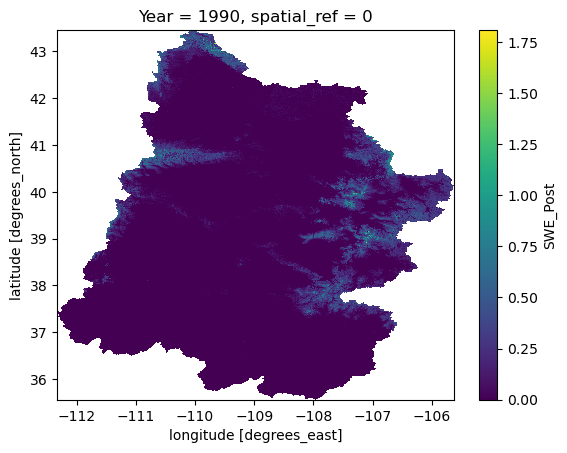

In [11]:
swe.SWE_Post[0].plot()

In [3]:
huc2 = gpd.read_file('../data/huc2.geojson')

In [4]:
huc2['huc2'] = huc2['huc2'].astype('int')

In [5]:
ucrb = huc2[huc2['huc2']==14]

In [87]:
ucrb

huc2    areaacres   areasqkm  \
5    14  72542420.79  293569.06   

                                              states  \
5  COCOCOWYAZ,NMAZ,NMCO,NMCO,NMCO,NMCO,NMCO,NMCO,...   

                                               huc10  \
5  1401000107140100011014010003021404010108140801...   

                                                name  \
5  Muddy CreekRock CreekUpper Eagle RiverMuddy Cr...   

                                            geometry  
5  POLYGON ((-110.93089 36.58755, -110.93103 36.5...

In [6]:
ucrb = ucrb.to_crs('epsg:4326')

In [254]:
ucrb.to_pickle('../data/misc/ucrb.pkl')

In [6]:
ucrb = pickle.load(open('../data/misc/ucrb.pkl','rb'))

In [7]:
clusters_reanalysis = xr.open_dataset('../data/swe_reanalysis_5clusters.nc')

In [8]:
clusters_reanalysis = clusters_reanalysis.__xarray_dataarray_variable__

In [9]:
clusters_reanalysis  = clusters_reanalysis.rio.write_crs('epsg:4326')

In [10]:
clusters_reanalysis.rio.crs

CRS.from_epsg(4326)

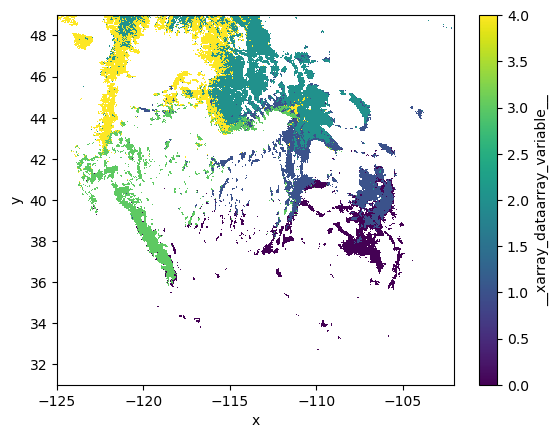

In [71]:
clusters_reanalysis.plot()

In [11]:
clusters_ucrb = clusters_reanalysis.rio.clip(ucrb.geometry)

In [12]:
clusters_ucrb

<xarray.DataArray '__xarray_dataarray_variable__' (y: 221, x: 188)> Size: 332kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 2kB 35.6 35.64 35.68 35.71 ... 43.36 43.39 43.43
  * x            (x) float64 2kB -112.3 -112.3 -112.2 ... -105.7 -105.7 -105.6
    spatial_ref  int64 8B 0

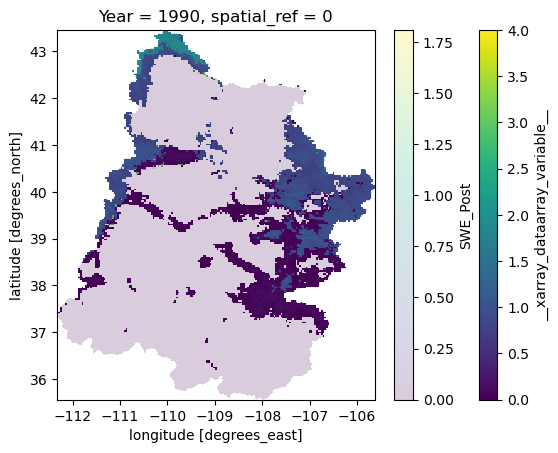

In [120]:
fig, ax = plt.subplots()
clusters_ucrb.plot(ax=ax)
swe.SWE_Post[0].plot(ax=ax, alpha=0.2)

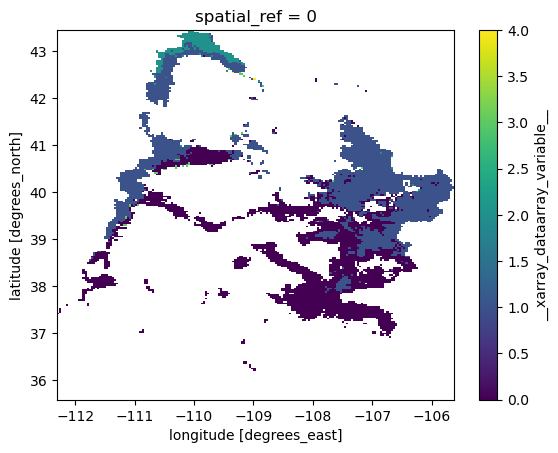

In [99]:
clusters_ucrb.plot()

### Calculate SWE by grid cell with cluster snv mean:

In [12]:
clusters_reanalysis_match = clusters_ucrb.rio.reproject_match(swe)

In [13]:
stations_ucrb = stations.clip(ucrb)

<Axes: >

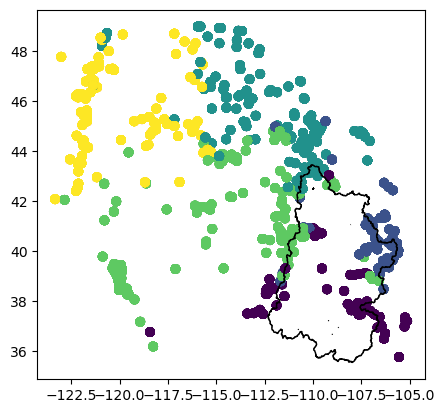

In [35]:
fig, ax = plt.subplots()
stations.plot(ax=ax, column='cluster')
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')

<Axes: >

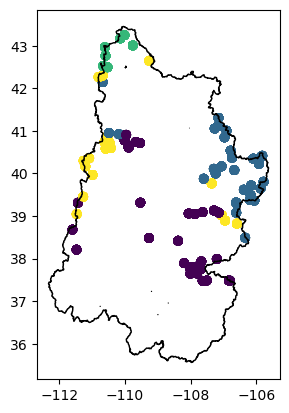

In [36]:
fig, ax = plt.subplots()
stations_ucrb.plot(ax=ax, column='cluster')
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')

### Make empty data arrays for the SNVs and Calculate SWE:

In [14]:
mean_snv = xr.full_like(swe.SWE_Post, np.nan)
calculated_swe = xr.full_like(swe.SWE_Post, np.nan)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

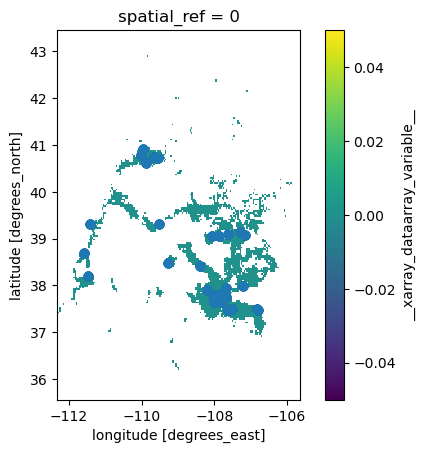

In [56]:
fig, ax = plt.subplots()
clusters_reanalysis_match.where(clusters_reanalysis_match == 0).plot(ax=ax)
stations_ucrb[stations_ucrb['cluster']==0].plot(ax=ax)

### Make data array of mean snvs for each cluster and year:

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

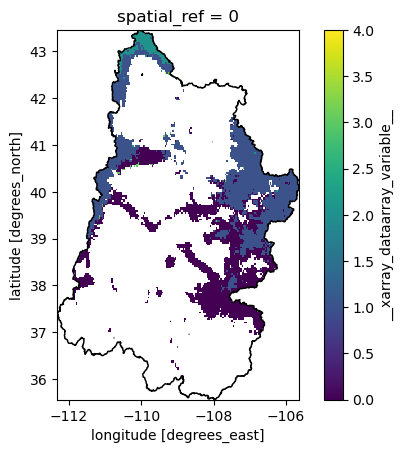

In [51]:
fig, ax = plt.subplots()
clusters_reanalysis_match.plot(cmap='viridis')
#clusters_ucrb.plot(ax=ax, cmap='Blues')
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')

In [15]:
for year in np.arange(0,32):
    for cluster in np.arange(0,4):
        mean_snv[year] = mean_snv[year].where(clusters_reanalysis_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['cluster']==cluster)]['station_n'].mean())

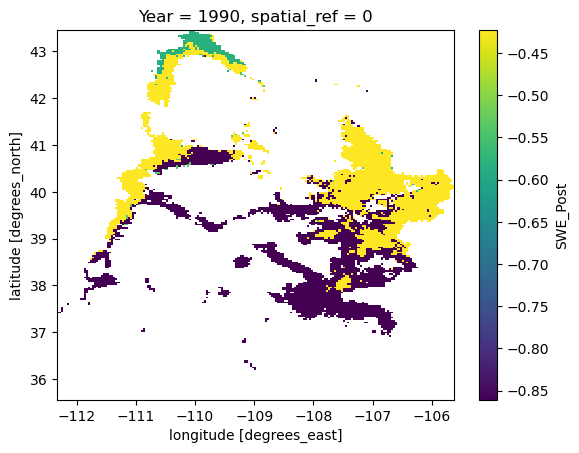

In [144]:
mean_snv[0].plot()

### Calculate SWE, excluding the 'current' year:

In [16]:
for year in np.arange(0,32):
    to_exclude = [year]
    years = [element for i, element in enumerate(np.arange(1990,2022)) if i not in to_exclude]
    calculated_swe[year] = mean_snv[year] * swe.SWE_Post.sel(Year=years).std(dim='Year', skipna=True, ddof=1).where(swe.SWE_Post.mean(dim='Year')>0.1) + swe.SWE_Post.sel(Year=years).mean(dim='Year').where(swe.SWE_Post.mean(dim='Year')>0.1)

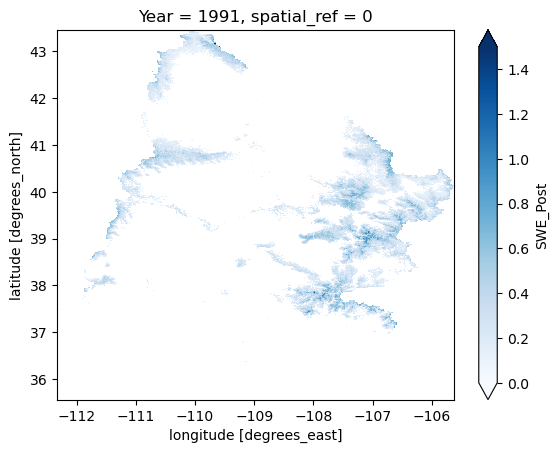

In [16]:
calculated_swe[1].plot(cmap='Blues',vmin=0,vmax=1.5)

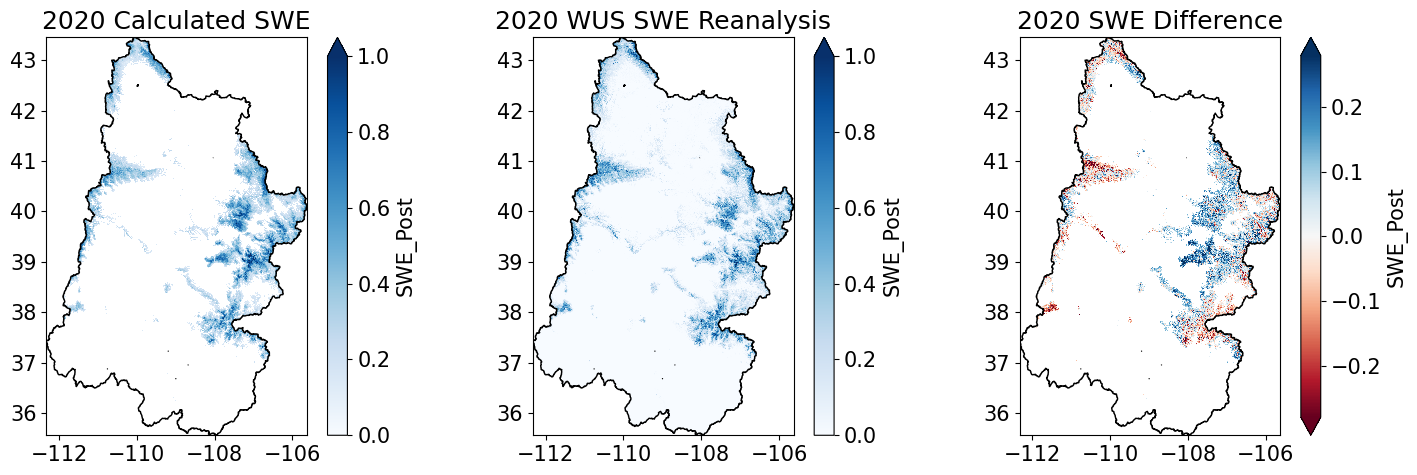

In [593]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,3, figsize=(15,5))

calculated_swe[30].plot(cmap='Blues', ax=ax[0], vmin=0,vmax=1)
ucrb.plot(ax=ax[0], facecolor='none', edgecolor='k')
swe.SWE_Post[30].plot(cmap='Blues', ax=ax[1], vmin=0,vmax=1)
ucrb.plot(ax=ax[1], facecolor='none', edgecolor='k')
dif_swe[30].plot(cmap='RdBu', ax=ax[2], robust=True)
ucrb.plot(ax=ax[2], facecolor='none', edgecolor='k')

ax[0].set_title('2020 Calculated SWE')
ax[1].set_title('2020 WUS SWE Reanalysis')
ax[2].set_title('2020 SWE Difference')

ax[0].set_xlabel('')
ax[0].set_ylabel('')

ax[1].set_xlabel('')
ax[1].set_ylabel('')

ax[2].set_xlabel('')
ax[2].set_ylabel('')

plt.tight_layout()
plt.savefig('../figures/calculated_swe_mean_snv_2020.jpeg',dpi=300)

In [352]:
calculated_swe.to_netcdf('../data/calculated_swe/calculated_swe_wic_mean.nc')

### Compare to Reanalysis from the 'current' year:

In [35]:
dif_swe = calculated_swe - swe.SWE_Post

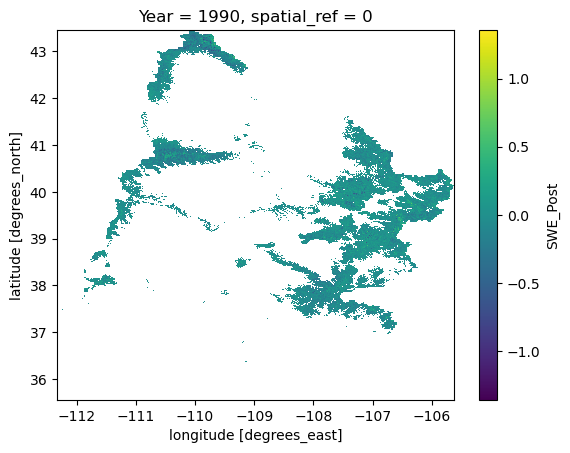

In [36]:
dif_swe[0].plot(cmap='viridis')

In [108]:
Rs = []
MDs = []
RMSEs = []

for year in np.arange(0,32):
    Rs.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten(), calculated_swe[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten())[0,1])
    MDs.append(dif_swe[year].values[dif_swe[year].notnull()].mean())
    RMSEs.append(np.sqrt(((calculated_swe[year].values[calculated_swe[year].notnull()] - swe.SWE_Post[year].values[calculated_swe[year].notnull()].flatten()) ** 2).mean()))

In [38]:
r = np.corrcoef(swe.SWE_Post.values[swe.SWE_Post.notnull() & calculated_swe.notnull()].flatten(), calculated_swe.values[swe.SWE_Post.notnull() & calculated_swe.notnull()].flatten())[0,1]
md = dif_swe.values[dif_swe.notnull()].mean()
rmse = np.sqrt(((calculated_swe.values[calculated_swe.notnull()] - swe.SWE_Post.values[calculated_swe.notnull()].flatten()) ** 2).mean())

In [42]:
print(r)
Rs

0.798136713283125


[0.7867145989795483,
 0.7549838550928634,
 0.6511541779193608,
 0.7968699037613457,
 0.7803052633363416,
 0.7680623534594491,
 0.8093511708939412,
 0.8474189115585249,
 0.7714957520414327,
 0.8125463680254047,
 0.7843332135671437,
 0.7617744948157789,
 0.7780024292890865,
 0.8013892749870005,
 0.8721774008343746,
 0.7551983375476351,
 0.8702779986471558,
 0.8252583873414864,
 0.8384010164323409,
 0.8153464254299109,
 0.5894688275725114,
 0.8472684727428379,
 0.7251391224609243,
 0.8056684346376377,
 0.7324073761117059,
 0.8213070284314301,
 0.7704634556950019,
 0.7973632751340415,
 0.8158395093274632,
 0.7811255888630463,
 0.797618629909432,
 0.6701704147492235]

In [43]:
print(md)
MDs

-0.00043269902


[-0.025591247,
 0.017817507,
 -0.06939142,
 -0.0053696437,
 0.02858751,
 0.034160655,
 0.038124118,
 0.08560423,
 -0.069802076,
 -0.002519265,
 -0.0098099625,
 -0.0016830899,
 -0.06459334,
 0.033608604,
 -0.045125283,
 -0.039240777,
 0.01754741,
 0.0070872637,
 0.053512108,
 0.080314346,
 -0.062466465,
 0.09783507,
 -0.08523618,
 -0.024278497,
 0.026739664,
 -0.040884912,
 0.0064369664,
 -0.023530832,
 0.0030967332,
 -0.009426391,
 0.03216826,
 0.0024625883]

In [44]:
print(rmse)
RMSEs

0.13511856


[0.112247035,
 0.116194904,
 0.19895461,
 0.1290711,
 0.1066725,
 0.14879672,
 0.17169313,
 0.15090707,
 0.1600289,
 0.10926807,
 0.117903806,
 0.107353136,
 0.12853925,
 0.12773119,
 0.116974995,
 0.158524,
 0.11094045,
 0.09950838,
 0.12337383,
 0.13924499,
 0.15392445,
 0.15293203,
 0.15669025,
 0.0910648,
 0.16807373,
 0.10006513,
 0.1279056,
 0.17048697,
 0.10152718,
 0.13759117,
 0.12592588,
 0.12631859]

### Calculate SWE using nearest within-cluster SNOTEL:

### Make a data array containing the SNV of the nearest within-cluster snotel:

In [45]:
nearest_station = xr.full_like(clusters_reanalysis_match.rio.reproject('epsg:32612'), np.nan)

In [46]:
nearest_station

<xarray.DataArray '__xarray_dataarray_variable__' (y: 1978, x: 1350)> Size: 21MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 11kB 3.798e+05 3.803e+05 ... 9.865e+05 9.869e+05
  * y            (y) float64 16kB 4.825e+06 4.825e+06 ... 3.936e+06 3.935e+06
    spatial_ref  int64 8B 0

### Make a dataframe with only one geometry per station:

In [47]:
stations_1yr = stations_ucrb[stations_ucrb.index.get_level_values(1) == 1990]
stations_1yr = stations_1yr.reset_index(level=1, drop=True)

In [48]:
stations_1yr.columns

Index(['station_n', 'reanalysis_n', 'elevation_m', 'station_swe',
       'station_swe_mean', 'reanalysis_swe', 'deg_days_0C', 'cold_deg_days',
       'cumulative_precip_m', 'precip_mean', 'precip_std', 'precip_n',
       'log_cumulative_precip_m', 'log_reanalysis_swe', 'log_station_swe',
       'log_precip_mean', 'log_station_swe_mean', 'log_reanalysis_swe_mean',
       'log_precip_std', 'log_station_swe_std', 'log_reanalysis_swe_std',
       'log_precip_n', 'log_station_n', 'log_reanalysis_n', 'latitude',
       'longitude', 'geometry', 'cluster', 'sampled_reanalysis_cluster',
       'reanalysis_cluster'],
      dtype='object')

### And add an id column for numerical indexing:

In [49]:
stations_1yr['id'] = np.nan

In [50]:
for i in range(len(stations_1yr)):
    stations_1yr.loc[stations_1yr.index[i], 'id'] = i

### Convert to UTM to compute distances:

In [51]:
stations_1yr = stations_1yr.to_crs('epsg:32612')

In [52]:
nearest_station_utm = nearest_station.rio.reproject('epsg:32612')

In [53]:
clusters_reanalysis_match_utm = clusters_reanalysis_match.rio.reproject('epsg:32612')

### We'll use scipy.spatial cKDTree for efficient distance metrics:

In [54]:
from scipy.spatial import cKDTree

In [56]:
for cluster in np.arange(0,4):
    
    tree = cKDTree(np.c_[stations_1yr[stations_1yr['cluster']==cluster].geometry.x.values,stations_1yr[stations_1yr['cluster']==cluster].geometry.y.values])
    indices = np.where(clusters_reanalysis_match_utm == cluster)

    # Extract coordinates from indices in data1
    query_points = []
    for i in range(len(indices[0])):
        y_index = indices[0][i]
        x_index = indices[1][i]
        x_coord = nearest_station.coords['x'].values[x_index]
        y_coord = nearest_station.coords['y'].values[y_index]
        query_points.append((x_coord, y_coord))
    dist, idx = tree.query(query_points, k=1)
    for i in np.arange(len(query_points)):
        nearest_station.loc[dict(x=query_points[i][0], y=query_points[i][1])] = stations_1yr[stations_1yr['cluster']==cluster].iloc[idx[i]]['id']

KeyboardInterrupt: 

In [ ]:
#nearest_station.to_netcdf('../data/calculated_swe/nearest_station_wic.nc')

In [60]:
nearest_station = xr.open_dataset('../data/calculated_swe/nearest_station_wic.nc')

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

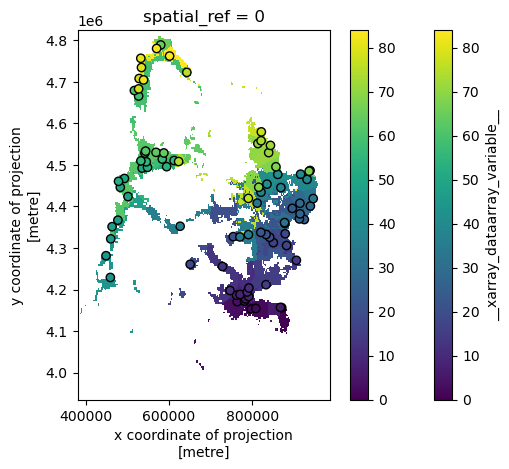

In [272]:
fig, ax = plt.subplots()
nearest_station.plot(ax=ax)
stations_1yr.plot(ax=ax,column='id', edgecolor='k',legend=True)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

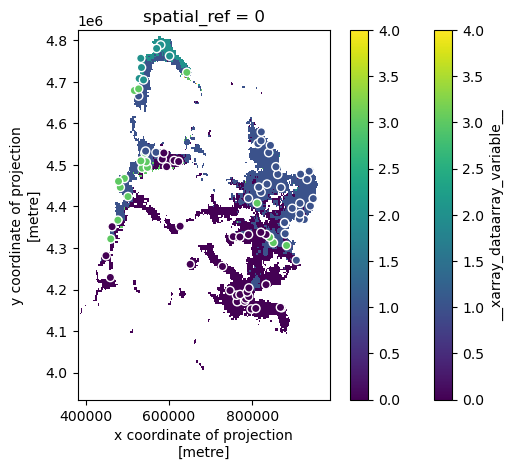

In [258]:
fig, ax = plt.subplots()
clusters_reanalysis_match_utm.plot(ax=ax)
stations_1yr.plot(ax=ax,column='cluster', edgecolor='white',legend=True, vmin=0,vmax=4)

## Use the look-up data array of nearest SNOTEL ids to make a data array with SNVs for each year from that SNOTEL:

### First, create an empty data array to populate:

In [ ]:
nearest_snv = xr.full_like(swe.SWE_Post, np.nan)

In [ ]:
nearest_station_4326 = nearest_station.rio.reproject('epsg:4326')

In [ ]:
nearest_station_4326 = nearest_station.rio.reproject_match(nearest_snv)

In [ ]:
site_ids = list(np.unique(nearest_station_4326.data))
site_ids_nan = site_ids[0:-1]

for i in site_ids_nan:
    for year in range(0,32):
        nearest_snv[year] = nearest_snv[year].where((nearest_station_4326 != i), stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['station_n'].values[0])

In [354]:
# nearest_snv.to_netcdf('../data/calculated_swe/nearest_station_snv_wic.nc')

In [61]:
nearest_snv = xr.open_dataarray('../data/calculated_swe/nearest_station_snv_wic.nc')

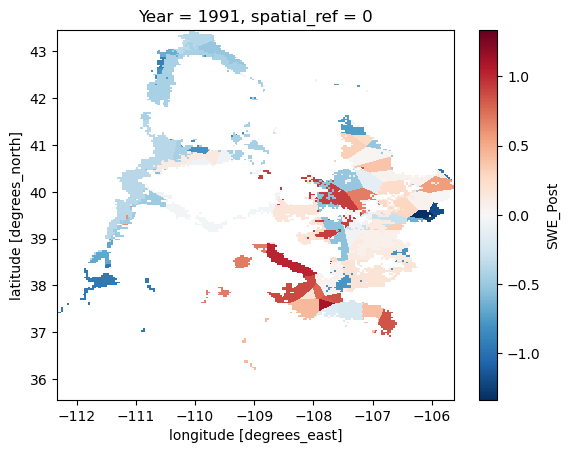

In [493]:
nearest_snv[1].plot()

In [ ]:
swe_calc_nearest = xr.full_like(swe.SWE_Post, np.nan)

In [ ]:
for year in np.arange(0,32):
    to_exclude = [year]
    years = [element for i, element in enumerate(np.arange(1990,2022)) if i not in to_exclude]
    swe_calc_nearest[year] = nearest_snv[year] * swe.SWE_Post.sel(Year=years).std(dim='Year', skipna=True, ddof=1).where(swe.SWE_Post.mean(dim='Year')>0.1) + swe.SWE_Post.sel(Year=years).mean(dim='Year').where(swe.SWE_Post.mean(dim='Year')>0.1)

In [ ]:
for year in np.arange(0,32):
    to_exclude = [year]
    years = [element for i, element in enumerate(np.arange(1990,2022)) if i not in to_exclude]

In [355]:
#swe_calc_nearest.to_netcdf('../data/calculated_swe/calculated_swe_nearest_station_wic.nc')

In [62]:
swe_calc_nearest = xr.open_dataarray('../data/calculated_swe/calculated_swe_nearest_station_wic.nc')

### Compare to Reanalysis from the 'current' year:

In [63]:
dif_swe2 = swe_calc_nearest - swe.SWE_Post

In [64]:
R2s = []
MD2s = []
RMSE2s = []

for year in np.arange(0,32):
    R2s.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & swe_calc_nearest[year].notnull()].flatten(), swe_calc_nearest[year].values[swe.SWE_Post[year].notnull() & swe_calc_nearest[year].notnull()].flatten())[0,1])
    MD2s.append(dif_swe2[year].values[dif_swe2[year].notnull()].mean())
    RMSE2s.append(np.sqrt(((swe_calc_nearest[year].values[swe_calc_nearest[year].notnull()] - swe.SWE_Post[year].values[swe_calc_nearest[year].notnull()].flatten()) ** 2).mean()))

In [65]:
r2 = np.corrcoef(swe.SWE_Post.values[swe.SWE_Post.notnull() & swe_calc_nearest.notnull()].flatten(), swe_calc_nearest.values[swe.SWE_Post.notnull() & swe_calc_nearest.notnull()].flatten())[0,1]
md2 = dif_swe2.values[dif_swe2.notnull()].mean()
rmse2 = np.sqrt(((swe_calc_nearest.values[swe_calc_nearest.notnull()] - swe.SWE_Post.values[swe_calc_nearest.notnull()].flatten()) ** 2).mean())

In [66]:
print(r2)
R2s

0.7748093458186383


[0.7179012900723387,
 0.7066229783254251,
 0.5911660537607684,
 0.7552721427735177,
 0.7737671876994188,
 0.7880988161831425,
 0.8098154650312444,
 0.776658450839922,
 0.7358192930474224,
 0.7539882272005491,
 0.7497198783952629,
 0.720891565334264,
 0.7330641136838935,
 0.7767324708362217,
 0.7983075192811031,
 0.7554537469444853,
 0.8574946610325933,
 0.7767664115518853,
 0.7769572898330169,
 0.7629810259839073,
 0.6038414076386613,
 0.804791390253112,
 0.6875711420304295,
 0.7610116302361676,
 0.7206048958811226,
 0.7710660552241977,
 0.715691551838401,
 0.7566682517954878,
 0.7948160732003909,
 0.7420656861631201,
 0.7799855829638173,
 0.6267895967918427]

In [44]:
R_dif = np.subtract(Rs, R2s)

Text(0, 0.5, 'Mean - Nearest (Difference in Rs')

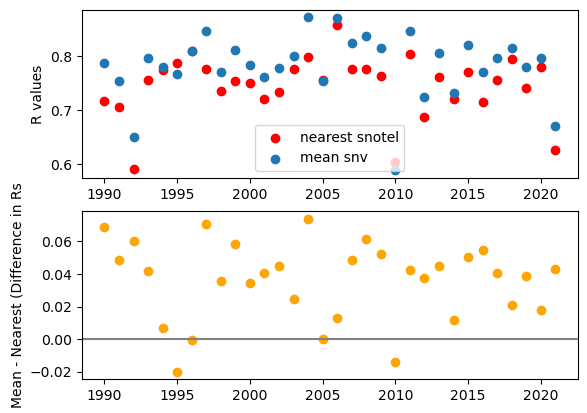

In [542]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(np.arange(1990, 2022), R2s, color='red', label='nearest snotel')
ax1.scatter(np.arange(1990, 2022), Rs, label='mean snv')
ax1.legend(loc='lower center')
ax1.set_ylabel('R values')

ax2.scatter(np.arange(1990, 2022), np.subtract(Rs, R2s), color = 'orange', label='mean snv')
ax2.axhline(0, color='grey')
ax2.set_ylabel('Mean - Nearest (Difference in Rs')

Text(0, 0.5, 'Mean - Nearest (Difference in MDs')

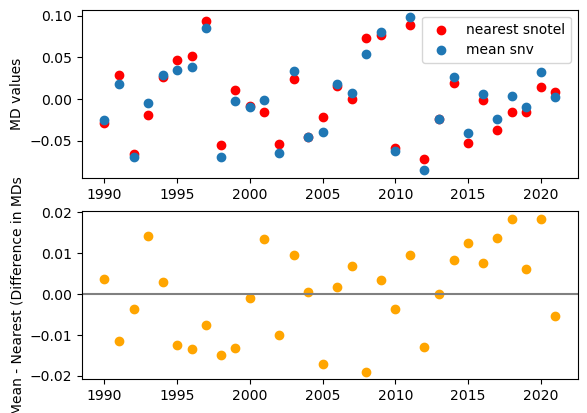

In [544]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(np.arange(1990, 2022), MD2s, color='red', label='nearest snotel')
ax1.scatter(np.arange(1990, 2022), MDs, label='mean snv')
ax1.legend(loc='best')
ax1.set_ylabel('MD values')

ax2.scatter(np.arange(1990, 2022), np.subtract(MDs, MD2s), color = 'orange', label='mean snv')
ax2.axhline(0, color='grey')
ax2.set_ylabel('Mean - Nearest (Difference in MDs')

Text(0, 0.5, 'Mean - Nearest (Difference in RMSEs')

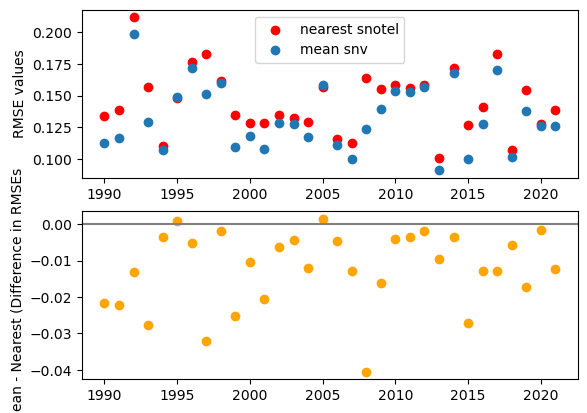

In [545]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(np.arange(1990, 2022), RMSE2s, color='red', label='nearest snotel')
ax1.scatter(np.arange(1990, 2022), RMSEs, label='mean snv')
ax1.legend(loc='best')
ax1.set_ylabel('RMSE values')

ax2.scatter(np.arange(1990, 2022), np.subtract(RMSEs, RMSE2s), color = 'orange', label='mean snv')
ax2.axhline(0, color='grey')
ax2.set_ylabel('Mean - Nearest (Difference in RMSEs')

In [67]:
print(md2)
MD2s

-0.0005262956


[-0.029213086,
 0.029248185,
 -0.06563987,
 -0.019597499,
 0.025780119,
 0.04657259,
 0.05159048,
 0.0931227,
 -0.054871254,
 0.0107915895,
 -0.008679113,
 -0.015068219,
 -0.054547798,
 0.024164774,
 -0.045556396,
 -0.022142109,
 0.01596535,
 0.0003456314,
 0.072533,
 0.07687012,
 -0.05885146,
 0.088404596,
 -0.07232723,
 -0.024119876,
 0.018540185,
 -0.05320957,
 -0.0010882004,
 -0.0370936,
 -0.015189733,
 -0.015455768,
 0.013940369,
 0.007939658]

In [68]:
print(rmse2)
RMSE2s

0.14697272


[0.1339645,
 0.13846575,
 0.2120238,
 0.15665637,
 0.1101275,
 0.14791687,
 0.17695256,
 0.18311591,
 0.16197349,
 0.13440587,
 0.12822281,
 0.12802522,
 0.13469222,
 0.13196449,
 0.12888344,
 0.15708898,
 0.115612805,
 0.112396024,
 0.16386959,
 0.15532644,
 0.15810077,
 0.15641667,
 0.15868397,
 0.10052843,
 0.17166783,
 0.1271323,
 0.1407492,
 0.18335477,
 0.10731382,
 0.15483676,
 0.12754582,
 0.13871229]

### Now calculate SWE using the nearest SNOTEL regardless of cluster:

In [45]:
nearest_station_nc = xr.full_like(clusters_reanalysis_match.rio.reproject('epsg:32612'), np.nan)

In [46]:
stations_1yr_utm = stations_1yr.to_crs('epsg:32612')

In [47]:
nearest_station_nc_utm = nearest_station_nc.rio.reproject('epsg:32612')

In [553]:
np.where(~np.isnan(clusters_reanalysis_match_utm))

(array([  32,   32,   32, ..., 1817, 1817, 1817]),
 array([429, 430, 431, ..., 671, 672, 673]))

In [550]:
clusters_reanalysis_match_utm

<xarray.DataArray '__xarray_dataarray_variable__' (y: 1978, x: 1350)> Size: 21MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 11kB 3.798e+05 3.803e+05 ... 9.865e+05 9.869e+05
  * y            (y) float64 16kB 4.825e+06 4.825e+06 ... 3.936e+06 3.935e+06
    spatial_ref  int64 8B 0

In [557]:
indices

(array([0, 0, 0, ..., 1, 1, 1]),
 array([     0,      1,      2, ..., 418274, 418275, 418276]))

In [48]:
tree = cKDTree(np.c_[stations_1yr_utm.geometry.x.values,stations_1yr_utm.geometry.y.values])
indices = np.where(~np.isnan(clusters_reanalysis_match_utm))

# Extract coordinates from indices in data1
query_points = []
for i in range(len(indices[0])):
    y_index = indices[0][i]
    x_index = indices[1][i]
    x_coord = nearest_station_nc_utm.coords['x'].values[x_index]
    y_coord = nearest_station_nc_utm.coords['y'].values[y_index]
    query_points.append((x_coord, y_coord))
dist, idx = tree.query(query_points, k=1)
for i in np.arange(len(query_points)):
    nearest_station_nc_utm.loc[dict(x=query_points[i][0], y=query_points[i][1])] = stations_1yr_utm.iloc[idx[i]]['id']

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

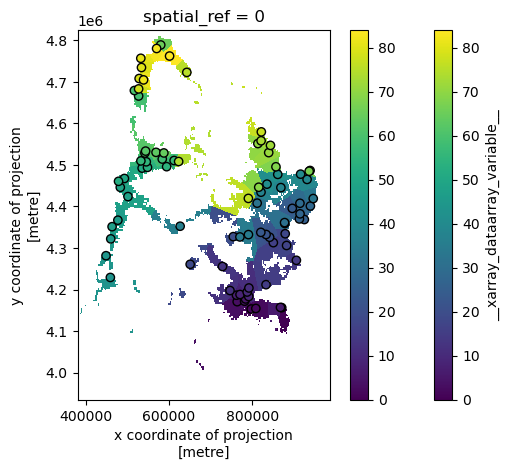

In [559]:
fig, ax = plt.subplots()
nearest_station_nc_utm.plot(ax=ax)
stations_1yr_utm.plot(ax=ax,column='id', edgecolor='k',legend=True)

In [49]:
nearest_snv_nc = xr.full_like(swe.SWE_Post, np.nan)

In [50]:
nearest_station_nc_4326 = nearest_station_nc_utm.rio.reproject_match(nearest_snv_nc)

In [356]:
nearest_station_nc_4326.to_netcdf('../data/calculated_swe/nearest_station.nc')

In [51]:
site_ids = list(np.unique(nearest_station_nc_4326.data))
site_ids_nan = site_ids[0:-1]

for i in site_ids_nan:
    for year in range(0,32):
        nearest_snv_nc[year] = nearest_snv_nc[year].where((nearest_station_nc_4326 != i), stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['station_n'].values[0])

In [357]:
nearest_snv_nc.to_netcdf('../data/calculated_swe/nearest_station_snv_nc.nc')

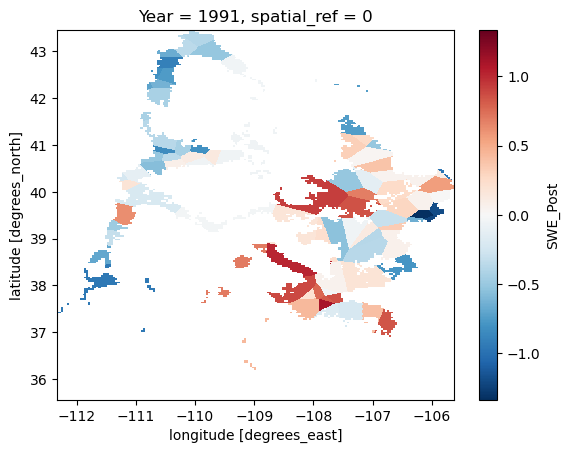

In [564]:
nearest_snv_nc[1].plot()

In [52]:
swe_calc_nearest_nc = xr.full_like(swe.SWE_Post, np.nan)

In [53]:
for year in np.arange(0,32):
    to_exclude = [year]
    years = [element for i, element in enumerate(np.arange(1990,2022)) if i not in to_exclude]
    swe_calc_nearest_nc[year] = nearest_snv_nc[year] * swe.SWE_Post.sel(Year=years).std(dim='Year', skipna=True, ddof=1).where(swe.SWE_Post.mean(dim='Year')>0.1) + swe.SWE_Post.sel(Year=years).mean(dim='Year').where(swe.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees

In [358]:
#swe_calc_nearest_nc.to_netcdf('../data/calculated_swe/calculated_swe_nearest_station_nc.nc')

In [69]:
swe_calc_nearest_nc = xr.open_dataarray('../data/calculated_swe/calculated_swe_nearest_station_nc.nc')

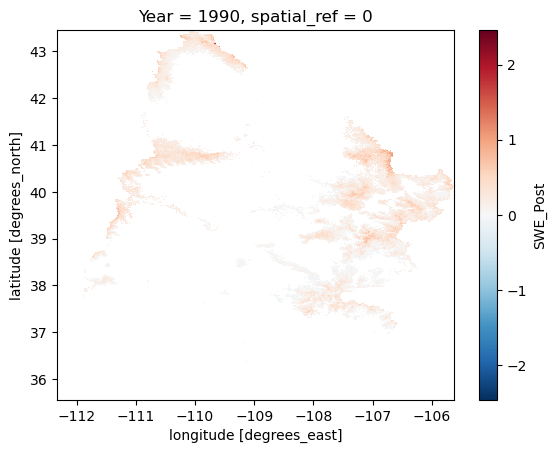

In [568]:
swe_calc_nearest_nc[0].plot()

### Compare to Reanalysis from the 'current' year:

In [70]:
dif_swe3 = swe_calc_nearest_nc - swe.SWE_Post

In [71]:
R3s = []
MD3s = []
RMSE3s = []

for year in np.arange(0,32):
    R3s.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & swe_calc_nearest_nc[year].notnull()].flatten(), swe_calc_nearest_nc[year].values[swe.SWE_Post[year].notnull() & swe_calc_nearest_nc[year].notnull()].flatten())[0,1])
    MD3s.append(dif_swe3[year].values[dif_swe3[year].notnull()].mean())
    RMSE3s.append(np.sqrt(((swe_calc_nearest_nc[year].values[swe_calc_nearest_nc[year].notnull()] - swe.SWE_Post[year].values[swe_calc_nearest_nc[year].notnull()].flatten()) ** 2).mean()))

In [72]:
r3 = np.corrcoef(swe.SWE_Post.values[swe.SWE_Post.notnull() & swe_calc_nearest_nc.notnull()].flatten(), swe_calc_nearest_nc.values[swe.SWE_Post.notnull() & swe_calc_nearest_nc.notnull()].flatten())[0,1]
md3 = dif_swe3.values[dif_swe3.notnull()].mean()
rmse3 = np.sqrt(((swe_calc_nearest_nc.values[swe_calc_nearest_nc.notnull()] - swe.SWE_Post.values[swe_calc_nearest_nc.notnull()].flatten()) ** 2).mean())

In [73]:
print(r)
print(md)
print(rmse)

0.798136713283125
-0.00043269902
0.13511856


In [74]:
print(r3)
print(md3)
print(rmse3)

0.7861427543568354
-0.00057910016
0.14318849


### Calculate SNV using mean of all snotel in the basin:

In [13]:
calculated_swe_all_mean = xr.full_like(swe.SWE_Post, np.nan)

In [14]:
for year in np.arange(0,32):
    to_exclude = [year]
    years = [element for i, element in enumerate(np.arange(1990,2022)) if i not in to_exclude]
    calculated_swe_all_mean[year] = stations_ucrb[stations_ucrb.index.get_level_values(1) == (year+1990)]['station_n'].mean() * swe.SWE_Post.sel(Year=years).std(dim='Year', skipna=True, ddof=1).where(swe.SWE_Post.mean(dim='Year')>0.1) + swe.SWE_Post.sel(Year=years).mean(dim='Year').where(swe.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees

In [359]:
#calculated_swe_all_mean.to_netcdf('../data/calculated_swe/calculated_swe_all_mean_nc.nc')

In [75]:
calculated_swe_all_mean = xr.open_dataarray('../data/calculated_swe/calculated_swe_all_mean_nc.nc')

### Compare to Reanalysis from the 'current' year:

In [76]:
dif_swe4 = calculated_swe_all_mean - swe.SWE_Post

In [77]:
R4s = []
MD4s = []
RMSE4s = []

for year in np.arange(0,32):
    R4s.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & calculated_swe_all_mean[year].notnull()].flatten(), calculated_swe_all_mean[year].values[swe.SWE_Post[year].notnull() & calculated_swe_all_mean[year].notnull()].flatten())[0,1])
    MD4s.append(dif_swe4[year].values[dif_swe4[year].notnull()].mean())
    RMSE4s.append(np.sqrt(((calculated_swe_all_mean[year].values[calculated_swe_all_mean[year].notnull()] - swe.SWE_Post[year].values[calculated_swe_all_mean[year].notnull()].flatten()) ** 2).mean()))

In [78]:
r4 = np.corrcoef(swe.SWE_Post.values[swe.SWE_Post.notnull() & calculated_swe_all_mean.notnull()].flatten(), calculated_swe_all_mean.values[swe.SWE_Post.notnull() & calculated_swe_all_mean.notnull()].flatten())[0,1]
md4 = dif_swe4.values[dif_swe4.notnull()].mean()
rmse4 = np.sqrt(((calculated_swe_all_mean.values[calculated_swe_all_mean.notnull()] - swe.SWE_Post.values[calculated_swe_all_mean.notnull()].flatten()) ** 2).mean())

In [79]:
print(r4)
print(md4)
print(rmse4)

0.7854121084486403
-0.00022720596
0.13804497


Text(0, 0.5, 'Mean - Nearest (Difference in Rs)')

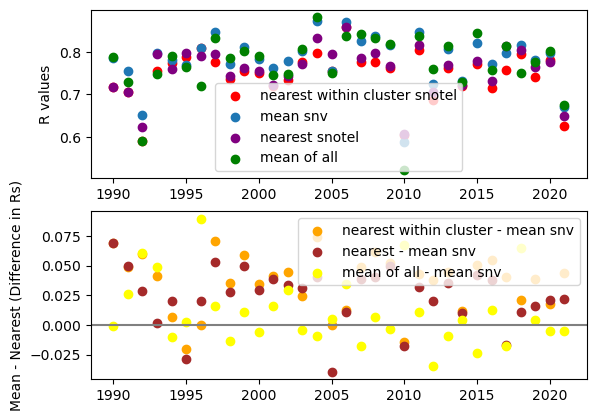

In [57]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(np.arange(1990, 2022), R2s, color='red', label='nearest within cluster snotel')
ax1.scatter(np.arange(1990, 2022), Rs, label='mean snv')
ax1.scatter(np.arange(1990, 2022), R3s, color='purple', label='nearest snotel')
ax1.scatter(np.arange(1990, 2022), R4s, color='green', label='mean of all')
ax1.legend(loc='lower center')
ax1.set_ylabel('R values')

ax2.scatter(np.arange(1990, 2022), np.subtract(Rs, R2s), color = 'orange', label='nearest within cluster - mean snv')
ax2.scatter(np.arange(1990, 2022), np.subtract(Rs, R3s), color = 'brown', label='nearest - mean snv')
ax2.scatter(np.arange(1990, 2022), np.subtract(Rs, R4s), color = 'yellow', label='mean of all - mean snv')
ax2.axhline(0, color='grey')
ax2.legend(loc='best')
ax2.set_ylabel('Mean - Nearest (Difference in Rs)')

Years with especially bad r values: 1992, 2010, 2021  

Text(0, 0.5, 'Mean - Nearest (Difference in MDs')

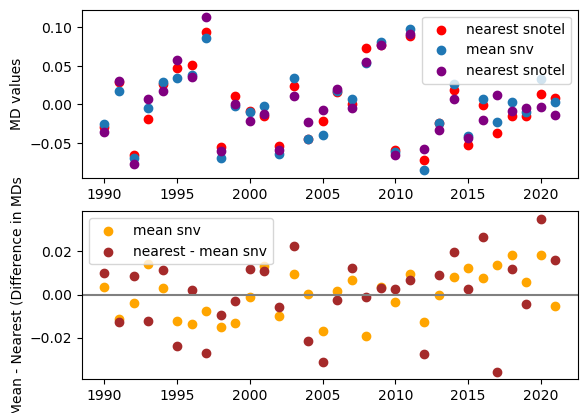

In [579]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(np.arange(1990, 2022), MD2s, color='red', label='nearest snotel')
ax1.scatter(np.arange(1990, 2022), MDs, label='mean snv')
ax1.scatter(np.arange(1990, 2022), MD3s, color='purple', label='nearest snotel')
ax1.legend(loc='best')
ax1.set_ylabel('MD values')

ax2.scatter(np.arange(1990, 2022), np.subtract(MDs, MD2s), color = 'orange', label='mean snv')
ax2.scatter(np.arange(1990, 2022), np.subtract(MDs, MD3s), color = 'brown', label='nearest - mean snv')
ax2.axhline(0, color='grey')
ax2.legend(loc='best')
ax2.set_ylabel('Mean - Nearest (Difference in MDs')

Years with bad MD: 1997, 2011, 2008, 2009? But not as bad of outliers here

Text(0, 0.5, 'Mean - Nearest (Difference in RMSEs')

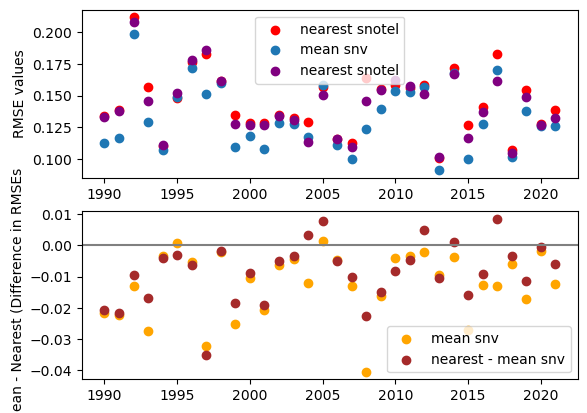

In [580]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(np.arange(1990, 2022), RMSE2s, color='red', label='nearest snotel')
ax1.scatter(np.arange(1990, 2022), RMSEs, label='mean snv')
ax1.scatter(np.arange(1990, 2022), RMSE3s, color='purple', label='nearest snotel')
ax1.legend(loc='best')
ax1.set_ylabel('RMSE values')

ax2.scatter(np.arange(1990, 2022), np.subtract(RMSEs, RMSE2s), color = 'orange', label='mean snv')
ax2.scatter(np.arange(1990, 2022), np.subtract(RMSEs, RMSE3s), color = 'brown', label='nearest - mean snv')
ax2.axhline(0, color='grey')
ax2.legend(loc='best')
ax2.set_ylabel('Mean - Nearest (Difference in RMSEs')

Years with bad RMSE values: 1992, 1996, 1997

In [596]:
print(np.std(Rs))
print(np.std(MDs))
print(np.std(RMSEs))

0.05899240714016815
0.045260824
0.025445297


In [597]:
print(np.std(R2s))
print(np.std(MD2s))
print(np.std(RMSE2s))

0.0560970975260333
0.04469006
0.024609227


In [598]:
print(np.std(R3s))
print(np.std(MD3s))
print(np.std(RMSE3s))

0.055420575747347725
0.04457641
0.024175309


In [58]:
print(np.std(R4s))
print(np.std(MD4s))
print(np.std(RMSE4s))

0.07110704040949727
0.044875458
0.02908534


In [599]:
print(np.subtract(*np.percentile(Rs, [75, 25])))
print(np.subtract(*np.percentile(MDs, [75, 25])))
print(np.subtract(*np.percentile(RMSEs, [75, 25])))

0.04897930760576741
0.05848632799461484
0.04125974886119366


In [600]:
print(np.subtract(*np.percentile(R2s, [75, 25])))
print(np.subtract(*np.percentile(MD2s, [75, 25])))
print(np.subtract(*np.percentile(RMSE2s, [75, 25])))

0.055994233151189565
0.05575182382017374
0.03007315844297409


In [601]:
print(np.subtract(*np.percentile(R3s, [75, 25])))
print(np.subtract(*np.percentile(MD3s, [75, 25])))
print(np.subtract(*np.percentile(RMSE3s, [75, 25])))

0.06444368725569016
0.04385079862549901
0.028424788266420364


In [59]:
print(np.subtract(*np.percentile(R4s, [75, 25])))
print(np.subtract(*np.percentile(MD4s, [75, 25])))
print(np.subtract(*np.percentile(RMSE4s, [75, 25])))

0.0676351874724912
0.046331103425472975
0.03975060023367405


In [95]:
cs_precip_rm = xr.open_dataarray('../data/calculated_swe/calculated_swe_prism_cumulative_coldseason_precip.nc')

In [96]:
type(cs_precip_rm)

xarray.core.dataarray.DataArray

In [98]:
dif_swe_precip = cs_precip_rm - swe_time.SWE_Post

In [100]:
swe_time = swe.rename(Year="time")
swe_time['time'] = xr.cftime_range(start="1990", periods=32, freq="YS-APR", calendar="noleap")

In [104]:
swe_time

<xarray.Dataset> Size: 343MB
Dimensions:      (y: 1776, x: 1508, time: 32)
Coordinates:
  * y            (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x            (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * time         (time) object 256B 1990-04-01 00:00:00 ... 2021-04-01 00:00:00
    spatial_ref  int64 8B ...
Data variables:
    SWE_Post     (time, y, x) float32 343MB nan nan nan nan ... nan nan nan nan

In [123]:
Rs_precip = []
MDs_precip = []
RMSEs_precip = []

for year in np.arange(1990,2022):
    Rs_precip.append(np.corrcoef(swe_time.SWE_Post.sel(time=f'{year}').values[swe_time.SWE_Post.sel(time=f'{year}').notnull() & cs_precip_rm.sel(time=f'{year}').notnull()].flatten(), cs_precip_rm.sel(time=f'{year}').values[swe_time.SWE_Post.sel(time=f'{year}').notnull() & cs_precip_rm.sel(time=f'{year}').notnull()].flatten())[0,1])
    MDs_precip.append(dif_swe_precip.sel(time=f'{year}').values[dif_swe_precip.sel(time=f'{year}').notnull()].mean())
    RMSEs_precip.append(np.sqrt(((cs_precip_rm.sel(time=f'{year}').values[cs_precip_rm.sel(time=f'{year}').notnull()] - swe_time.SWE_Post.sel(time=f'{year}').values[cs_precip_rm.sel(time=f'{year}').notnull()].flatten()) ** 2).mean()))

In [112]:
data = {
  "Rs": Rs,
    "MDs": MDs,
    "RMSEs": RMSEs,
    "version":"mean_wic"
}

#load data into a DataFrame object:
mean_df = pd.DataFrame(data)

In [113]:
data = {
    "Rs": R2s,
    "MDs": MD2s,
    "RMSEs":RMSE2s,
    "version":"nearest_wic"
}

#load data into a DataFrame object:
nearest_wic_df = pd.DataFrame(data)

In [114]:
data = {
    "Rs" : R3s, 
    "MDs": MD3s,
    "RMSEs":RMSE3s,
    "version":"nearest"
}

#load data into a DataFrame object:
nearest_df = pd.DataFrame(data)

In [115]:
data = {
    "Rs" : R4s, 
    "MDs": MD4s,
    "RMSEs":RMSE4s,
    "version":"all_mean"
}

#load data into a DataFrame object:
all_mean_df = pd.DataFrame(data)

In [124]:
data = {
    "Rs" : Rs_precip, 
    "MDs": MDs_precip,
    "RMSEs":RMSEs_precip,
    "version":"prism"
}

#load data into a DataFrame object:
prism_precip = pd.DataFrame(data)

In [126]:
metrics = pd.concat([mean_df, nearest_wic_df, nearest_df, all_mean_df, prism_precip], ignore_index=True)

In [127]:
import altair as alt

In [128]:
r_chart = alt.Chart(metrics).mark_boxplot().encode(
    alt.X("Rs:Q").scale(zero=False),
    alt.Y("version:N")
)

md_chart = alt.Chart(metrics).mark_boxplot().encode(
    alt.X("MDs:Q").scale(zero=False),
    alt.Y("version:N")
)

rmse_chart = alt.Chart(metrics).mark_boxplot().encode(
    alt.X("RMSEs:Q").scale(zero=False),
    alt.Y("version:N")
)

concat = alt.vconcat(r_chart, md_chart, rmse_chart)
concat

alt.VConcatChart(...)

# Now Recalculate these metrics using Cluster definitions from SWE Reanalysis:

### Calculate SWE by grid cell with cluster snv mean:

In [11]:
#clusters_reanalysis_match = clusters_ucrb.rio.reproject_match(swe)

In [86]:
stations_ucrb = stations.clip(ucrb)

<Axes: >

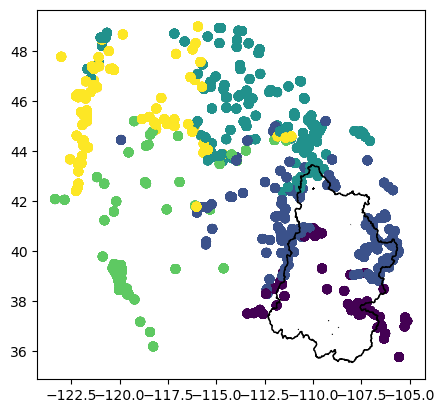

In [87]:
fig, ax = plt.subplots()
stations.plot(ax=ax, column='sampled_reanalysis_cluster')
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')

<Axes: >

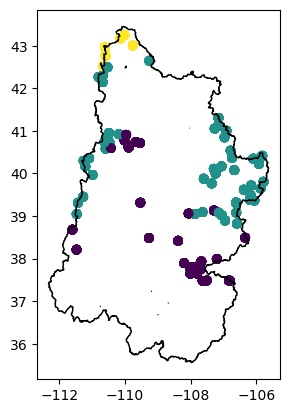

In [88]:
fig, ax = plt.subplots()
stations_ucrb.plot(ax=ax, column='sampled_reanalysis_cluster')
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')

### Make empty data arrays for the SNVs and Calculate SWE:

In [89]:
mean_snv_sc = xr.full_like(swe.SWE_Post, np.nan)
calculated_swe_sc = xr.full_like(swe.SWE_Post, np.nan)

### Make data array of mean snvs for each cluster and year:

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

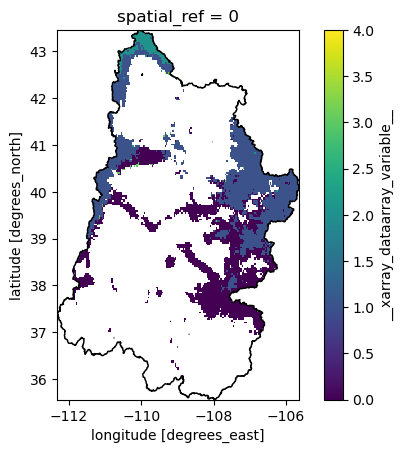

In [90]:
fig, ax = plt.subplots()
clusters_reanalysis_match.plot(cmap='viridis')
#clusters_ucrb.plot(ax=ax, cmap='Blues')
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')

In [91]:
for year in np.arange(0,32):
    for cluster in np.arange(0,4):
        mean_snv_sc[year] = mean_snv_sc[year].where(clusters_reanalysis_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['sampled_reanalysis_cluster']==cluster)]['station_n'].mean())

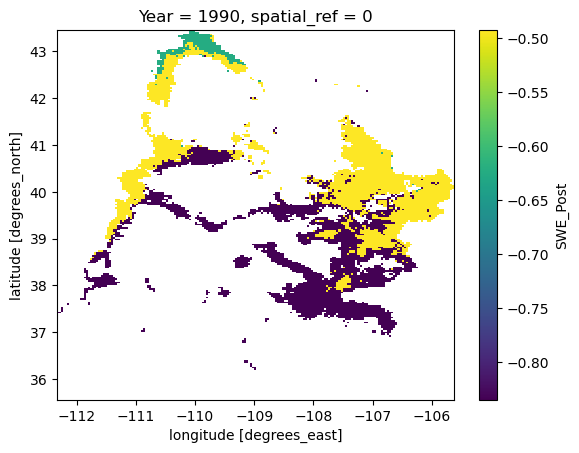

In [92]:
mean_snv_sc[0].plot()

In [117]:
stations_ucrb['sampled_reanalysis_cluster'].unique()

array([0., 1., 2.])

### Calculate SWE, excluding the 'current' year:

In [93]:
for year in np.arange(0,32):
    to_exclude = [year]
    years = [element for i, element in enumerate(np.arange(1990,2022)) if i not in to_exclude]
    calculated_swe_sc[year] = mean_snv_sc[year] * swe.SWE_Post.sel(Year=years).std(dim='Year', skipna=True, ddof=1).where(swe.SWE_Post.mean(dim='Year')>0.1) + swe.SWE_Post.sel(Year=years).mean(dim='Year').where(swe.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees

In [361]:
#calculated_swe_sc.to_netcdf('../data/calculated_swe/calculated_swe_mean_wic_sc.nc')

In [131]:
calculated_swe_sc = xr.open_dataarray('../data/calculated_swe/calculated_swe_mean_wic_sc.nc')

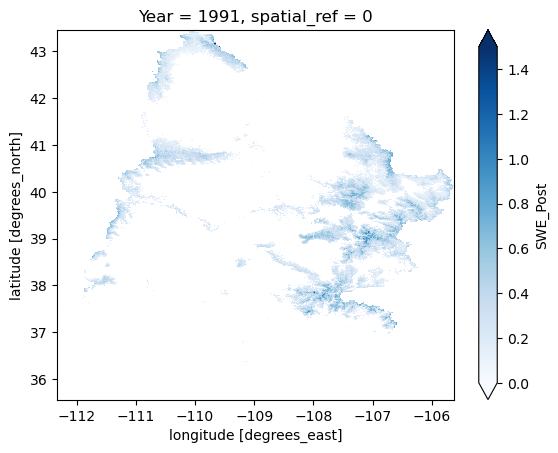

In [95]:
calculated_swe_sc[1].plot(cmap='Blues',vmin=0,vmax=1.5)

### Compare to Reanalysis from the 'current' year:

In [132]:
dif_swe_sc = calculated_swe_sc - swe.SWE_Post

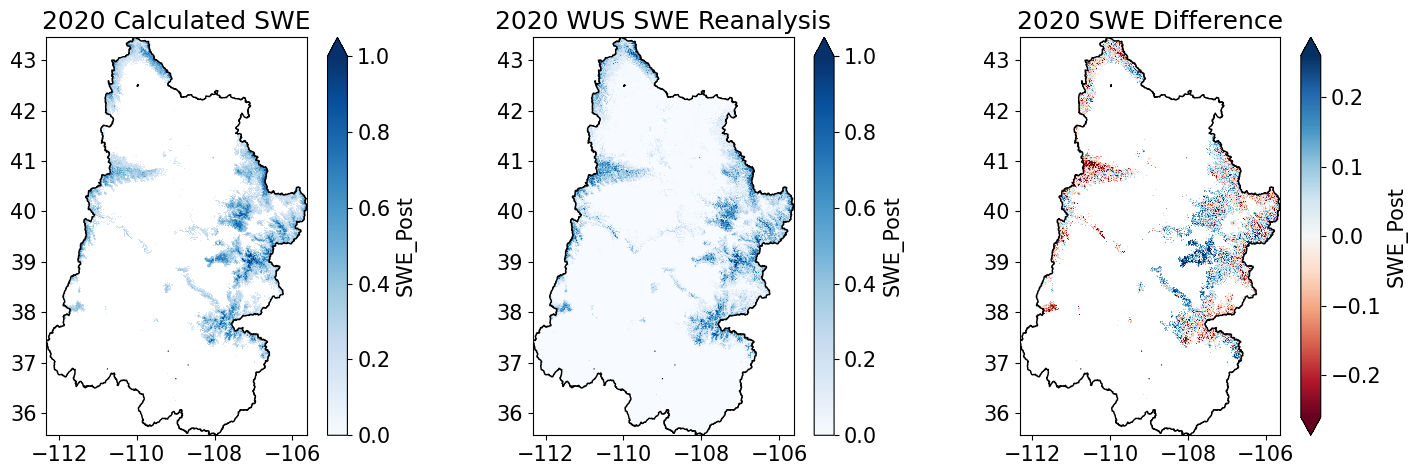

In [97]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,3, figsize=(15,5))

calculated_swe_sc[30].plot(cmap='Blues', ax=ax[0], vmin=0,vmax=1)
ucrb.plot(ax=ax[0], facecolor='none', edgecolor='k')
swe.SWE_Post[30].plot(cmap='Blues', ax=ax[1], vmin=0,vmax=1)
ucrb.plot(ax=ax[1], facecolor='none', edgecolor='k')
dif_swe_sc[30].plot(cmap='RdBu', ax=ax[2], robust=True)
ucrb.plot(ax=ax[2], facecolor='none', edgecolor='k')

ax[0].set_title('2020 Calculated SWE')
ax[1].set_title('2020 WUS SWE Reanalysis')
ax[2].set_title('2020 SWE Difference')

ax[0].set_xlabel('')
ax[0].set_ylabel('')

ax[1].set_xlabel('')
ax[1].set_ylabel('')

ax[2].set_xlabel('')
ax[2].set_ylabel('')

plt.tight_layout()
#plt.savefig('../figures/calculated_swe_mean_snv_2020.jpeg',dpi=300)

In [133]:
R_scs = []
MD_scs = []
RMSE_scs = []

for year in np.arange(0,32):
    R_scs.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & calculated_swe_sc[year].notnull()].flatten(), calculated_swe_sc[year].values[swe.SWE_Post[year].notnull() & calculated_swe_sc[year].notnull()].flatten())[0,1])
    MD_scs.append(dif_swe_sc[year].values[dif_swe_sc[year].notnull()].mean())
    RMSE_scs.append(np.sqrt(((calculated_swe_sc[year].values[calculated_swe_sc[year].notnull()] - swe.SWE_Post[year].values[calculated_swe_sc[year].notnull()].flatten()) ** 2).mean()))

In [134]:
r_sc = np.corrcoef(swe.SWE_Post.values[swe.SWE_Post.notnull() & calculated_swe_sc.notnull()].flatten(), calculated_swe_sc.values[swe.SWE_Post.notnull() & calculated_swe_sc.notnull()].flatten())[0,1]
md_sc = dif_swe_sc.values[dif_swe_sc.notnull()].mean()
rmse_sc = np.sqrt(((calculated_swe_sc.values[calculated_swe_sc.notnull()] - swe.SWE_Post.values[calculated_swe_sc.notnull()].flatten()) ** 2).mean())

In [100]:
print(r_sc)
R_scs

0.8067420692543982


[0.789344538337439,
 0.7551197053051627,
 0.6552793397746568,
 0.7948469005235163,
 0.7854394220543696,
 0.78888149552508,
 0.8118952209904686,
 0.849016568982016,
 0.7788010537589035,
 0.8124869685431371,
 0.7890153950381078,
 0.7620882560078622,
 0.7803468121680968,
 0.8134922000369197,
 0.8905519660481442,
 0.800228157903318,
 0.8685869921896187,
 0.8386040983501568,
 0.8415146229425586,
 0.8217913537277122,
 0.5886910341534904,
 0.8437653766746892,
 0.7672863508786487,
 0.8061581112645746,
 0.7348479076033637,
 0.8181185334987089,
 0.7622027996140763,
 0.8350340723466527,
 0.8158232069610561,
 0.7845234616989666,
 0.8009105667742414,
 0.6664693874408835]

In [101]:
print(md_sc)
MD_scs

-0.00044089105


[-0.030135829,
 0.017742313,
 -0.0846213,
 0.004136544,
 0.016752915,
 0.060467836,
 0.021550631,
 0.09752394,
 -0.061061062,
 0.0055555915,
 -0.022047786,
 -0.011469481,
 -0.059973728,
 0.0054648533,
 -0.026058897,
 0.0034174507,
 0.017462706,
 -0.0074808924,
 0.043265596,
 0.06173938,
 -0.062724195,
 0.09128694,
 -0.05473173,
 -0.028729912,
 0.002923597,
 -0.044781875,
 -0.017644454,
 0.039804336,
 0.00030531187,
 -0.002126317,
 0.015195743,
 -0.0051167817]

In [102]:
print(rmse_sc)
RMSE_scs

0.13187715


[0.11232163,
 0.11610076,
 0.20431197,
 0.12982427,
 0.1022043,
 0.15160987,
 0.16725557,
 0.15769824,
 0.15449658,
 0.109794356,
 0.11764226,
 0.107527025,
 0.12614045,
 0.11919372,
 0.105667375,
 0.138825,
 0.11184741,
 0.09667512,
 0.117760934,
 0.12676767,
 0.15420192,
 0.15087931,
 0.13452384,
 0.09221373,
 0.161259,
 0.10236605,
 0.1298811,
 0.16098876,
 0.10134289,
 0.13640243,
 0.12090607,
 0.12641491]

### Calculate SWE using nearest within-cluster SNOTEL:

### Make a data array containing the SNV of the nearest within-cluster snotel:

In [103]:
nearest_station_sc = xr.full_like(clusters_reanalysis_match.rio.reproject('epsg:32612'), np.nan)

### Make a dataframe with only one geometry per station:

In [104]:
stations_1yr = stations_ucrb[stations_ucrb.index.get_level_values(1) == 1990]
stations_1yr = stations_1yr.reset_index(level=1, drop=True)

In [105]:
stations_1yr.columns

Index(['station_n', 'reanalysis_n', 'elevation_m', 'station_swe',
       'station_swe_mean', 'reanalysis_swe', 'deg_days_0C', 'cold_deg_days',
       'cumulative_precip_m', 'precip_mean', 'precip_std', 'precip_n',
       'log_cumulative_precip_m', 'log_reanalysis_swe', 'log_station_swe',
       'log_precip_mean', 'log_station_swe_mean', 'log_reanalysis_swe_mean',
       'log_precip_std', 'log_station_swe_std', 'log_reanalysis_swe_std',
       'log_precip_n', 'log_station_n', 'log_reanalysis_n', 'latitude',
       'longitude', 'geometry', 'cluster', 'sampled_reanalysis_cluster',
       'reanalysis_cluster'],
      dtype='object')

### And add an id column for numerical indexing:

In [106]:
stations_1yr['id'] = np.nan

In [107]:
for i in range(len(stations_1yr)):
    stations_1yr.loc[stations_1yr.index[i], 'id'] = i

### Convert to UTM to compute distances:

In [108]:
stations_1yr = stations_1yr.to_crs('epsg:32612')

In [109]:
nearest_station_sc_utm = nearest_station_sc.rio.reproject('epsg:32612')

In [110]:
clusters_reanalysis_match_utm = clusters_reanalysis_match.rio.reproject('epsg:32612')

### We'll use scipy.spatial cKDTree for efficient distance metrics:

In [111]:
from scipy.spatial import cKDTree

In [119]:
for cluster in np.arange(0,3):
    
    tree = cKDTree(np.c_[stations_1yr[stations_1yr['sampled_reanalysis_cluster']==cluster].geometry.x.values,stations_1yr[stations_1yr['sampled_reanalysis_cluster']==cluster].geometry.y.values])
    indices = np.where(clusters_reanalysis_match_utm == cluster)

    # Extract coordinates from indices in data1
    query_points = []
    for i in range(len(indices[0])):
        y_index = indices[0][i]
        x_index = indices[1][i]
        x_coord = nearest_station.coords['x'].values[x_index]
        y_coord = nearest_station.coords['y'].values[y_index]
        query_points.append((x_coord, y_coord))
    dist, idx = tree.query(query_points, k=1)
    for i in np.arange(len(query_points)):
        nearest_station_sc.loc[dict(x=query_points[i][0], y=query_points[i][1])] = stations_1yr[stations_1yr['sampled_reanalysis_cluster']==cluster].iloc[idx[i]]['id']

In [362]:
#nearest_station_sc.to_netcdf('../data/calculated_swe/nearest_station_wic_sc.nc')

In [205]:
nearest_station_sc = xr.open_dataset('../data/calculated_swe/nearest_station_wic_sc.nc')
nearest_station_sc = nearest_station_sc.__xarray_dataarray_variable__

In [206]:
nearest_station = xr.open_dataset('../data/calculated_swe/nearest_station.nc')
nearest_station = nearest_station.__xarray_dataarray_variable__

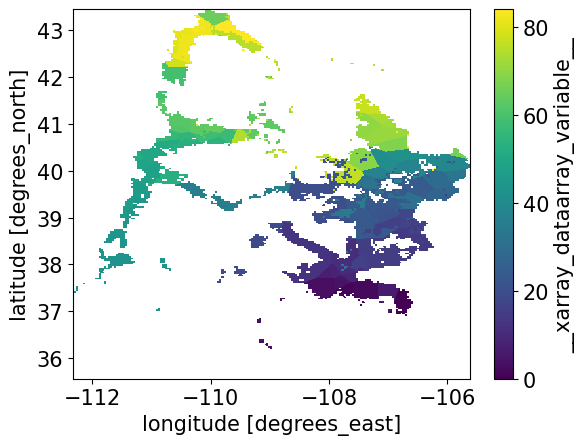

In [207]:
nearest_station_sc.plot()

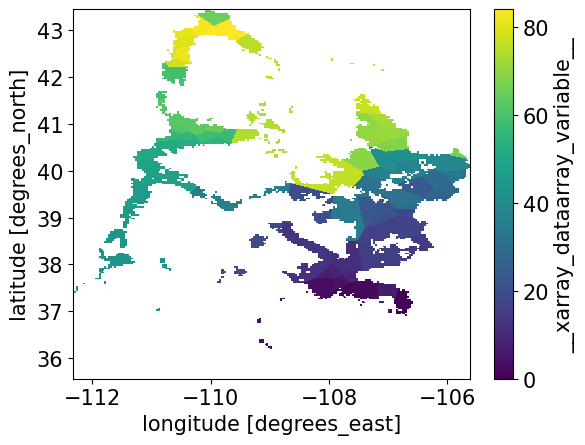

In [208]:
nearest_station.plot()

In [220]:
np.unique(nearest_station.values)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., nan])

In [224]:
np.count_nonzero(~np.isnan(nearest_station))

450213

In [226]:
nearest_station_1 = nearest_station + 1
np.count_nonzero(~np.isnan(nearest_station_1))

450213

In [228]:
np.unique(nearest_station_1.values)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82., 83., 84., 85., nan])

In [232]:
len(np.unique(station_differences.values))

48

In [233]:
binary_station_dif = xr.full_like(nearest_station, np.nan)

In [238]:
np.count_nonzero(~np.isnan(nearest_station.where(nearest_station != nearest_station_sc)))

92382

In [239]:
np.count_nonzero(~np.isnan(nearest_station.where(nearest_station == nearest_station_sc)))

357831

In [240]:
np.count_nonzero(~np.isnan(nearest_station.where(nearest_station == nearest_station_sc))) + np.count_nonzero(~np.isnan(nearest_station.where(nearest_station != nearest_station_sc)))

450213

In [242]:
np.count_nonzero(~np.isnan(nearest_station.where(nearest_station != nearest_station_sc))) / (np.count_nonzero(~np.isnan(nearest_station)))

0.2051962071286258

In [245]:
np.count_nonzero(~np.isnan(nearest_station.where(nearest_station == nearest_station_sc))) / (np.count_nonzero(~np.isnan(nearest_station)))

0.7948037928713743

## The nearest station is the same as the nearest within-cluster station in 79% of the snow-covered gridcells

In [209]:
station_differences = nearest_station - nearest_station_sc

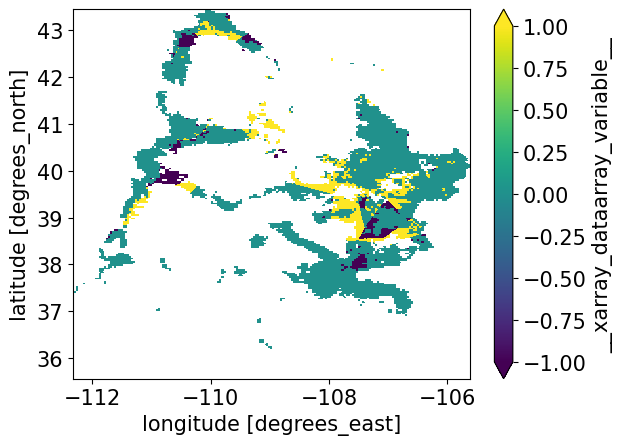

In [246]:
station_differences.plot(vmin=-1,vmax=1)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

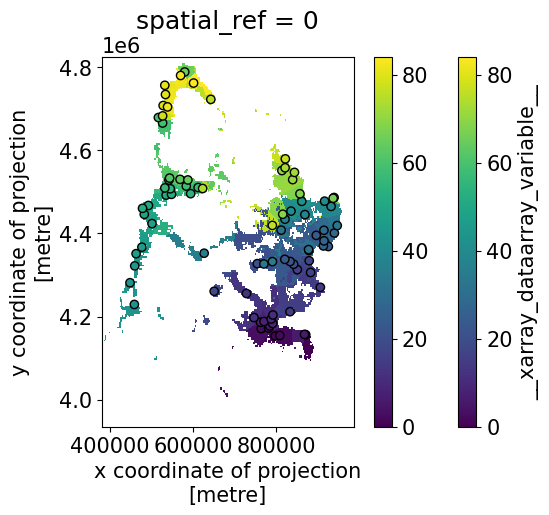

In [120]:
fig, ax = plt.subplots()
nearest_station_sc.plot(ax=ax)
stations_1yr.plot(ax=ax,column='id', edgecolor='k',legend=True)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

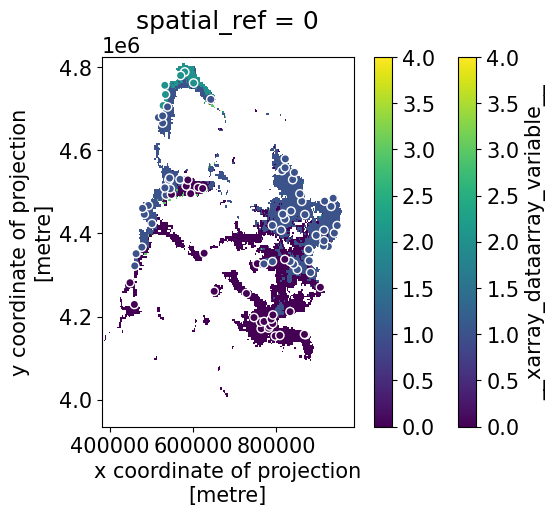

In [122]:
fig, ax = plt.subplots()
clusters_reanalysis_match_utm.plot(ax=ax)
stations_1yr.plot(ax=ax,column='sampled_reanalysis_cluster', edgecolor='white',legend=True, vmin=0,vmax=4)

In [199]:
nearest_station_sc

NameError: name 'nearest_station_sc' is not defined

## Use the look-up data array of nearest SNOTEL ids to make a data array with SNVs for each year from that SNOTEL:

### First, create an empty data array to populate:

In [123]:
nearest_snv_sc = xr.full_like(swe.SWE_Post, np.nan)

In [124]:
nearest_station_sc_4326 = nearest_station_sc.rio.reproject('epsg:4326')

In [125]:
nearest_station_sc_4326 = nearest_station_sc.rio.reproject_match(nearest_snv_sc)

In [366]:
nearest_station_sc_4326.to_netcdf('../data/calculated_swe/nearest_station_wic_sc.nc')

In [126]:
site_ids = list(np.unique(nearest_station_sc_4326.data))
site_ids_nan = site_ids[0:-1]

for i in site_ids_nan:
    for year in range(0,32):
        nearest_snv_sc[year] = nearest_snv_sc[year].where((nearest_station_sc_4326 != i), stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['station_n'].values[0])

In [363]:
nearest_snv_sc.to_netcdf('../data/calculated_swe/nearest_station_snv_wic_sc.nc')

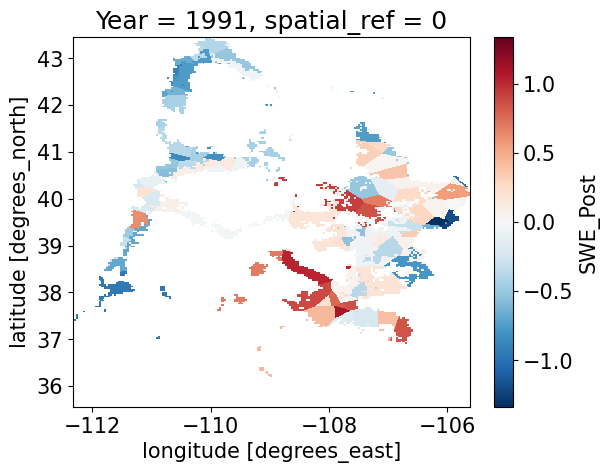

In [127]:
nearest_snv_sc[1].plot()

In [128]:
swe_calc_nearest_sc = xr.full_like(swe.SWE_Post, np.nan)

In [129]:
for year in np.arange(0,32):
    to_exclude = [year]
    years = [element for i, element in enumerate(np.arange(1990,2022)) if i not in to_exclude]
    swe_calc_nearest_sc[year] = nearest_snv_sc[year] * swe.SWE_Post.sel(Year=years).std(dim='Year', skipna=True, ddof=1).where(swe.SWE_Post.mean(dim='Year')>0.1) + swe.SWE_Post.sel(Year=years).mean(dim='Year').where(swe.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees

In [364]:
#swe_calc_nearest_sc.to_netcdf('../data/calculated_swe/calculated_swe_nearest_station_wic_sc.nc')

In [135]:
swe_calc_nearest_sc = xr.open_dataarray('../data/calculated_swe/calculated_swe_nearest_station_wic_sc.nc')

### Compare to Reanalysis from the 'current' year:

In [136]:
dif_swe2_sc = swe_calc_nearest_sc - swe.SWE_Post

In [137]:
R2s_sc = []
MD2s_sc = []
RMSE2s_sc = []

for year in np.arange(0,32):
    R2s_sc.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & swe_calc_nearest_sc[year].notnull()].flatten(), swe_calc_nearest_sc[year].values[swe.SWE_Post[year].notnull() & swe_calc_nearest_sc[year].notnull()].flatten())[0,1])
    MD2s_sc.append(dif_swe2_sc[year].values[dif_swe2_sc[year].notnull()].mean())
    RMSE2s_sc.append(np.sqrt(((swe_calc_nearest_sc[year].values[swe_calc_nearest_sc[year].notnull()] - swe.SWE_Post[year].values[swe_calc_nearest_sc[year].notnull()].flatten()) ** 2).mean()))

In [138]:
r2_sc = np.corrcoef(swe.SWE_Post.values[swe.SWE_Post.notnull() & swe_calc_nearest_sc.notnull()].flatten(), swe_calc_nearest_sc.values[swe.SWE_Post.notnull() & swe_calc_nearest_sc.notnull()].flatten())[0,1]
md2_sc = dif_swe2_sc.values[dif_swe2_sc.notnull()].mean()
rmse2_sc = np.sqrt(((swe_calc_nearest_sc.values[swe_calc_nearest_sc.notnull()] - swe.SWE_Post.values[swe_calc_nearest_sc.notnull()].flatten()) ** 2).mean())

In [134]:
print(r2_sc)
R2s_sc

0.7875964797175584


[0.7217069908854249,
 0.7143737171592702,
 0.6232600634246028,
 0.7890630019959963,
 0.7633522346539412,
 0.7973421739738488,
 0.7921583155148697,
 0.8034785869399609,
 0.7360051087274443,
 0.7637428878500275,
 0.7522791231303863,
 0.7289603700126409,
 0.7414643715625272,
 0.7716330728804183,
 0.8276550859791945,
 0.8001910240602637,
 0.8586658867432122,
 0.7852607075248517,
 0.799165351235,
 0.7627866116419618,
 0.6028642243565978,
 0.8189005732492913,
 0.7067874656288105,
 0.7650762442136941,
 0.720019194978062,
 0.7825055674470448,
 0.7326919049992017,
 0.8208974057209601,
 0.8049248931440409,
 0.7683080514149868,
 0.7681178617438743,
 0.6414743311164046]

In [44]:
R_dif = np.subtract(Rs, R2s)

Text(0, 0.5, 'Mean - Nearest (Difference in Rs')

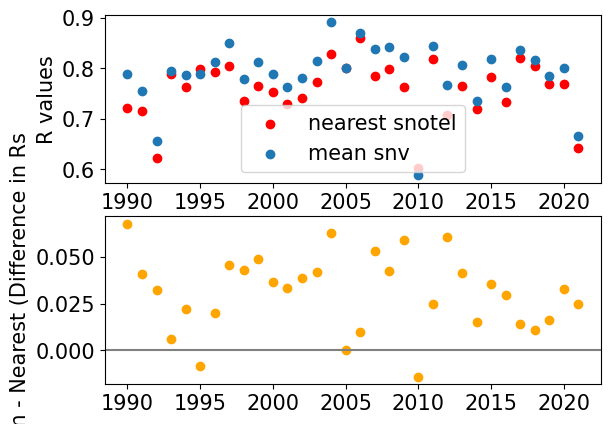

In [136]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(np.arange(1990, 2022), R2s_sc, color='red', label='nearest snotel')
ax1.scatter(np.arange(1990, 2022), R_scs, label='mean snv')
ax1.legend(loc='lower center')
ax1.set_ylabel('R values')

ax2.scatter(np.arange(1990, 2022), np.subtract(R_scs, R2s_sc), color = 'orange', label='mean snv')
ax2.axhline(0, color='grey')
ax2.set_ylabel('Mean - Nearest (Difference in Rs')

Text(0, 0.5, 'Mean - Nearest (Difference in MDs')

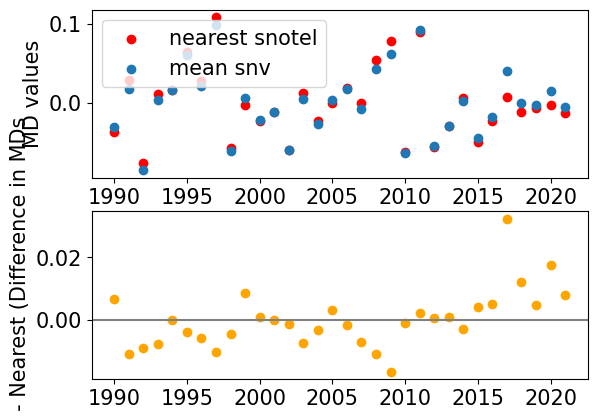

In [137]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(np.arange(1990, 2022), MD2s_sc, color='red', label='nearest snotel')
ax1.scatter(np.arange(1990, 2022), MD_scs, label='mean snv')
ax1.legend(loc='best')
ax1.set_ylabel('MD values')

ax2.scatter(np.arange(1990, 2022), np.subtract(MD_scs, MD2s_sc), color = 'orange', label='mean snv')
ax2.axhline(0, color='grey')
ax2.set_ylabel('Mean - Nearest (Difference in MDs')

Text(0, 0.5, 'Mean - Nearest (Difference in RMSEs')

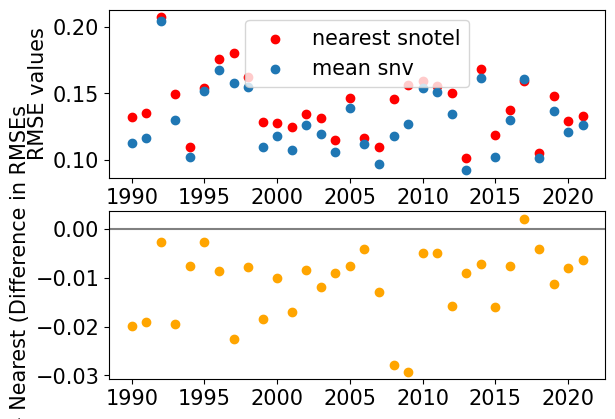

In [138]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(np.arange(1990, 2022), RMSE2s_sc, color='red', label='nearest snotel')
ax1.scatter(np.arange(1990, 2022), RMSE_scs, label='mean snv')
ax1.legend(loc='best')
ax1.set_ylabel('RMSE values')

ax2.scatter(np.arange(1990, 2022), np.subtract(RMSE_scs, RMSE2s_sc), color = 'orange', label='mean snv')
ax2.axhline(0, color='grey')
ax2.set_ylabel('Mean - Nearest (Difference in RMSEs')

In [139]:
print(md2_sc)
MD2s_sc

-0.00059124496


[-0.03684273,
 0.028696274,
 -0.07574677,
 0.011671224,
 0.016795525,
 0.06421157,
 0.027293012,
 0.107810654,
 -0.056507226,
 -0.0031102952,
 -0.023045823,
 -0.011389682,
 -0.05889504,
 0.012877756,
 -0.023028832,
 0.00017806774,
 0.019125441,
 -0.0006296081,
 0.054076545,
 0.07817836,
 -0.06168453,
 0.08890028,
 -0.055458263,
 -0.029686188,
 0.005854003,
 -0.048888445,
 -0.022746446,
 0.007507651,
 -0.011881042,
 -0.0070292978,
 -0.002339008,
 -0.013187009]

In [140]:
print(rmse2_sc)
RMSE2s_sc

0.14270844


[0.1321087,
 0.13509881,
 0.20703924,
 0.14932586,
 0.10984573,
 0.15416214,
 0.17583011,
 0.1802791,
 0.16218525,
 0.12827076,
 0.12760355,
 0.12458442,
 0.1346058,
 0.13103172,
 0.11472537,
 0.14646143,
 0.1159688,
 0.109621935,
 0.14570081,
 0.15601815,
 0.15908013,
 0.155768,
 0.15031706,
 0.10123165,
 0.16831852,
 0.11837868,
 0.13744901,
 0.158899,
 0.105392806,
 0.14775416,
 0.12897533,
 0.13272017]

# Now Recalculate these metrics using Clusters from just UCRB definitions from SWE Reanalysis:

### Calculate SWE by grid cell with cluster snv mean:

In [11]:
#clusters_reanalysis_match = clusters_ucrb.rio.reproject_match(swe)

In [255]:
stations_ucrb = pickle.load(open('../data/snv_dataframes/snv_temp_precip_cluster_gdf_snvs_ucrb.pkl','rb'))


In [259]:
clusters_ucrb = xr.open_dataset('../data/ucrb_swe_reanalysis_3clusters_8xcoarsened.nc')

In [260]:
clusters_ucrb = clusters_ucrb.__xarray_dataarray_variable__

In [261]:
clusters_ucrb  = clusters_ucrb.rio.write_crs('epsg:4326')

In [263]:
clusters_ucrb_match = clusters_ucrb.rio.reproject_match(swe)

<Axes: >

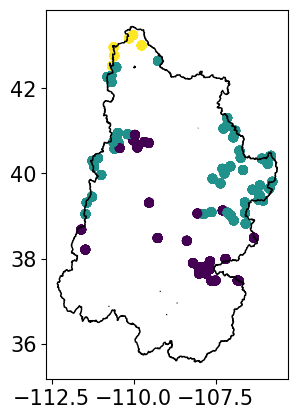

In [257]:
fig, ax = plt.subplots()
stations_ucrb.plot(ax=ax, column='sampled_reanalysis_cluster')
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')

<Axes: >

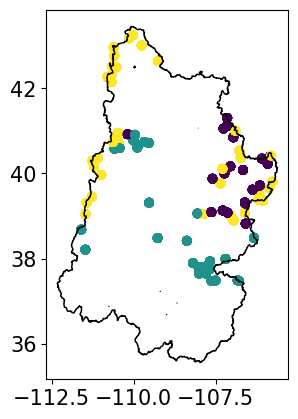

In [256]:
fig, ax = plt.subplots()
stations_ucrb.plot(ax=ax, column='sampled_reanalysis_cluster_ucrb')
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')

### Make empty data arrays for the SNVs and Calculate SWE:

In [258]:
mean_snv_sc2 = xr.full_like(swe.SWE_Post, np.nan)
calculated_swe_sc2 = xr.full_like(swe.SWE_Post, np.nan)

### Make data array of mean snvs for each cluster and year:

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

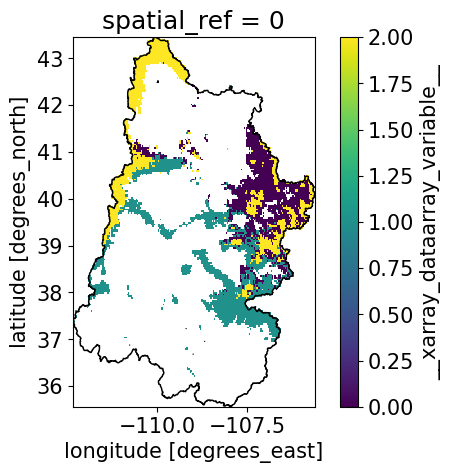

In [264]:
fig, ax = plt.subplots()
clusters_ucrb_match.plot(cmap='viridis')
#clusters_ucrb.plot(ax=ax, cmap='Blues')
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')

In [265]:
for year in np.arange(0,32):
    for cluster in np.arange(0,4):
        mean_snv_sc2[year] = mean_snv_sc2[year].where(clusters_ucrb_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['sampled_reanalysis_cluster_ucrb']==cluster)]['station_n'].mean())

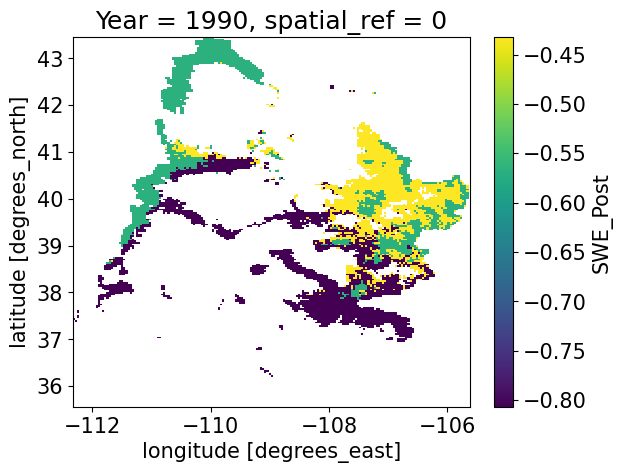

In [266]:
mean_snv_sc2[0].plot()

In [267]:
stations_ucrb['sampled_reanalysis_cluster_ucrb'].unique()

array([1., 0., 2.])

### Calculate SWE, excluding the 'current' year:

In [268]:
for year in np.arange(0,32):
    to_exclude = [year]
    years = [element for i, element in enumerate(np.arange(1990,2022)) if i not in to_exclude]
    calculated_swe_sc2[year] = mean_snv_sc2[year] * swe.SWE_Post.sel(Year=years).std(dim='Year', skipna=True, ddof=1).where(swe.SWE_Post.mean(dim='Year')>0.1) + swe.SWE_Post.sel(Year=years).mean(dim='Year').where(swe.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees

In [365]:
#calculated_swe_sc2.to_netcdf('../data/calculated_swe/calculated_swe_mean_sc2.nc')

In [139]:
calculated_swe_sc2 = xr.open_dataarray('../data/calculated_swe/calculated_swe_mean_sc2.nc')

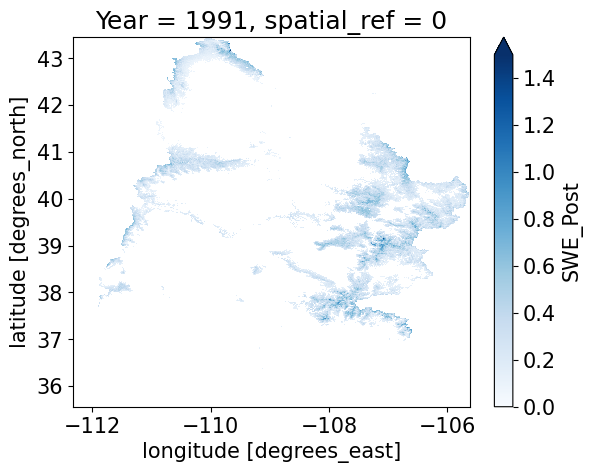

In [269]:
calculated_swe_sc2[1].plot(cmap='Blues',vmin=0,vmax=1.5)

### Compare to Reanalysis from the 'current' year:

In [140]:
dif_swe_sc2 = calculated_swe_sc2 - swe.SWE_Post

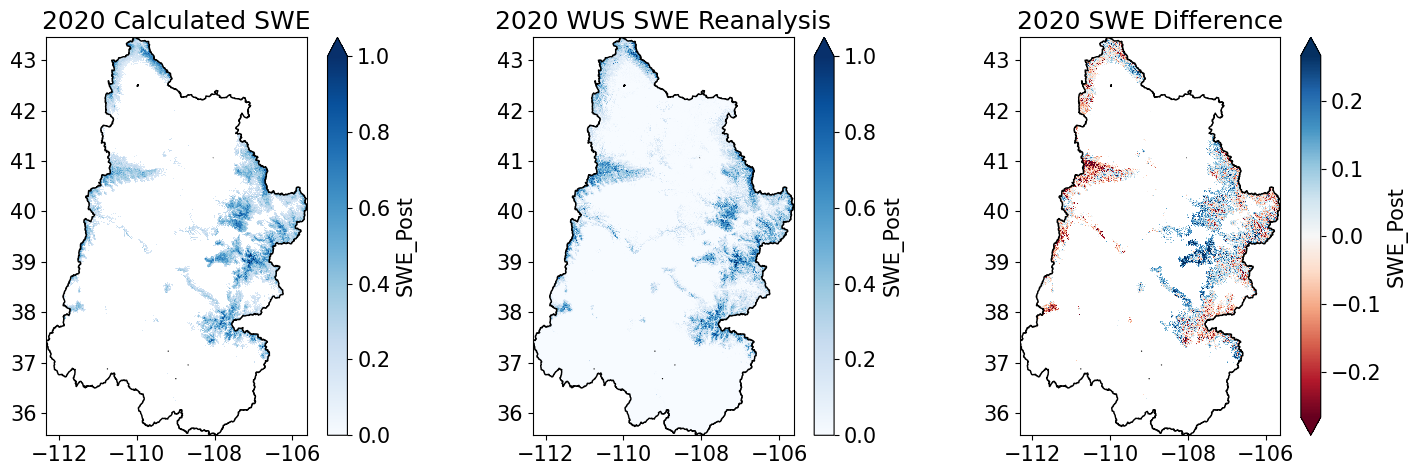

In [271]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,3, figsize=(15,5))

calculated_swe_sc2[30].plot(cmap='Blues', ax=ax[0], vmin=0,vmax=1)
ucrb.plot(ax=ax[0], facecolor='none', edgecolor='k')
swe.SWE_Post[30].plot(cmap='Blues', ax=ax[1], vmin=0,vmax=1)
ucrb.plot(ax=ax[1], facecolor='none', edgecolor='k')
dif_swe_sc2[30].plot(cmap='RdBu', ax=ax[2], robust=True)
ucrb.plot(ax=ax[2], facecolor='none', edgecolor='k')

ax[0].set_title('2020 Calculated SWE')
ax[1].set_title('2020 WUS SWE Reanalysis')
ax[2].set_title('2020 SWE Difference')

ax[0].set_xlabel('')
ax[0].set_ylabel('')

ax[1].set_xlabel('')
ax[1].set_ylabel('')

ax[2].set_xlabel('')
ax[2].set_ylabel('')

plt.tight_layout()
#plt.savefig('../figures/calculated_swe_mean_snv_2020.jpeg',dpi=300)

In [141]:
R_scs2 = []
MD_scs2 = []
RMSE_scs2 = []

for year in np.arange(0,32):
    R_scs2.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & calculated_swe_sc2[year].notnull()].flatten(), calculated_swe_sc2[year].values[swe.SWE_Post[year].notnull() & calculated_swe_sc2[year].notnull()].flatten())[0,1])
    MD_scs2.append(dif_swe_sc2[year].values[dif_swe_sc2[year].notnull()].mean())
    RMSE_scs2.append(np.sqrt(((calculated_swe_sc2[year].values[calculated_swe_sc2[year].notnull()] - swe.SWE_Post[year].values[calculated_swe_sc2[year].notnull()].flatten()) ** 2).mean()))

In [142]:
r_sc2 = np.corrcoef(swe.SWE_Post.values[swe.SWE_Post.notnull() & calculated_swe_sc2.notnull()].flatten(), calculated_swe_sc2.values[swe.SWE_Post.notnull() & calculated_swe_sc2.notnull()].flatten())[0,1]
md_sc2 = dif_swe_sc2.values[dif_swe_sc2.notnull()].mean()
rmse_sc2 = np.sqrt(((calculated_swe_sc2.values[calculated_swe_sc2.notnull()] - swe.SWE_Post.values[calculated_swe_sc2.notnull()].flatten()) ** 2).mean())

In [274]:
print(r_sc2)
R_scs2

0.8046790777076781


[0.7837819628327944,
 0.7282038969476108,
 0.6750339908869704,
 0.7783554278729161,
 0.778893253500474,
 0.7796121405808742,
 0.8173585352512018,
 0.8438813979635457,
 0.7800516798087511,
 0.7956521044260229,
 0.787873905519564,
 0.7727182819444004,
 0.7745974896170339,
 0.8098229985866494,
 0.8987611864832515,
 0.8012556493649302,
 0.8753364921199416,
 0.8422759135279249,
 0.815807925901369,
 0.8039301136492744,
 0.5842728044462576,
 0.8412068312785449,
 0.76036422303877,
 0.8132839721481475,
 0.746460277271726,
 0.8172799397039427,
 0.7643554574501716,
 0.8519642482379985,
 0.7811773834770557,
 0.7794770442016579,
 0.7901704379928748,
 0.676883068775967]

In [275]:
print(md_sc2)
MD_scs2

-0.00040783774


[-0.026453406,
 0.01772696,
 -0.087795444,
 2.3992205e-05,
 0.017872892,
 0.05293999,
 0.03196068,
 0.0991694,
 -0.06361523,
 0.008091791,
 -0.019835467,
 -0.0147585375,
 -0.05580701,
 0.011049776,
 -0.030549549,
 -0.0103077,
 0.02267295,
 -0.005317044,
 0.045643397,
 0.06802359,
 -0.069189444,
 0.09880591,
 -0.060274623,
 -0.028356792,
 0.011618004,
 -0.046141755,
 -0.015176377,
 0.029384108,
 0.0046160645,
 -0.009563591,
 0.016547084,
 -0.006055425]

In [276]:
print(rmse_sc2)
RMSE_scs2

0.13301249


[0.112873085,
 0.121210836,
 0.20378646,
 0.1341529,
 0.10383266,
 0.15152365,
 0.16724025,
 0.16107956,
 0.15557665,
 0.11586785,
 0.11762081,
 0.10551559,
 0.12595583,
 0.121579014,
 0.101863824,
 0.13951649,
 0.11101487,
 0.096767664,
 0.12580736,
 0.13431782,
 0.15596047,
 0.15648162,
 0.13884515,
 0.090572104,
 0.15838139,
 0.104779474,
 0.12948689,
 0.14721724,
 0.10927989,
 0.13893516,
 0.12438662,
 0.124039516]

## Use Quantile Mapping to Calculate SWE:

#### See quantile_mapping_gridded notebook for quantile calculations

In [143]:
swe_reanalysis_quantile_predictions = xr.load_dataset('../data/calculated_swe/calculated_swe_quantile_nearest_wic_sc.nc')

### Compare to Reanalysis

In [144]:
dif_swe_sc_quantile = swe_reanalysis_quantile_predictions - swe.SWE_Post

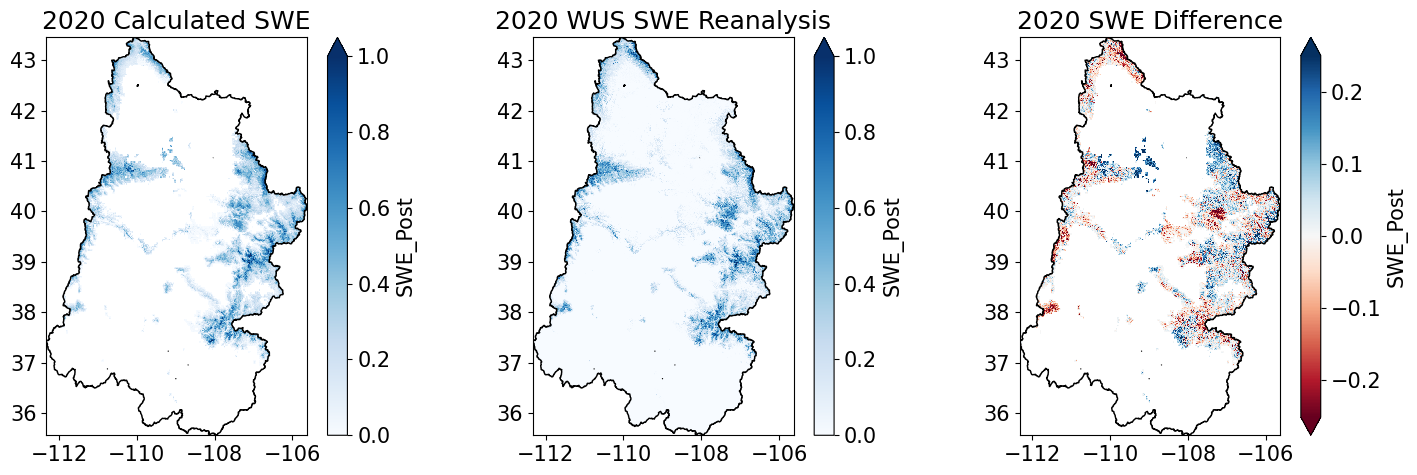

In [374]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,3, figsize=(15,5))

swe_reanalysis_quantile_predictions.SWE_Post[30].plot(cmap='Blues', ax=ax[0], vmin=0,vmax=1)
ucrb.plot(ax=ax[0], facecolor='none', edgecolor='k')
swe.SWE_Post[30].plot(cmap='Blues', ax=ax[1], vmin=0,vmax=1)
ucrb.plot(ax=ax[1], facecolor='none', edgecolor='k')
dif_swe_sc_quantile.SWE_Post[30].plot(cmap='RdBu', ax=ax[2], robust=True)
ucrb.plot(ax=ax[2], facecolor='none', edgecolor='k')

ax[0].set_title('2020 Calculated SWE')
ax[1].set_title('2020 WUS SWE Reanalysis')
ax[2].set_title('2020 SWE Difference')

ax[0].set_xlabel('')
ax[0].set_ylabel('')

ax[1].set_xlabel('')
ax[1].set_ylabel('')

ax[2].set_xlabel('')
ax[2].set_ylabel('')

plt.tight_layout()
#plt.savefig('../figures/calculated_swe_mean_snv_2020.jpeg',dpi=300)

In [145]:
R_scqs = []
MD_scqs = []
RMSE_scqs = []

for year in np.arange(0,32):
    R_scqs.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & swe_reanalysis_quantile_predictions.SWE_Post[year].notnull()].flatten(), swe_reanalysis_quantile_predictions.SWE_Post[year].values[swe.SWE_Post[year].notnull() & swe_reanalysis_quantile_predictions.SWE_Post[year].notnull()].flatten())[0,1])
    MD_scqs.append(dif_swe_sc_quantile.SWE_Post[year].values[dif_swe_sc_quantile.SWE_Post[year].notnull()].mean())
    RMSE_scqs.append(np.sqrt(((swe_reanalysis_quantile_predictions.SWE_Post[year].values[swe_reanalysis_quantile_predictions.SWE_Post[year].notnull()] - swe.SWE_Post[year].values[swe_reanalysis_quantile_predictions.SWE_Post[year].notnull()].flatten()) ** 2).mean()))

In [146]:
r_scq = np.corrcoef(swe.SWE_Post.values[swe.SWE_Post.notnull() & swe_reanalysis_quantile_predictions.SWE_Post.notnull()].flatten(), swe_reanalysis_quantile_predictions.SWE_Post.values[swe.SWE_Post.notnull() & swe_reanalysis_quantile_predictions.SWE_Post.notnull()].flatten())[0,1]
md_scq = dif_swe_sc_quantile.SWE_Post.values[dif_swe_sc_quantile.SWE_Post.notnull()].mean()
rmse_scq = np.sqrt(((swe_reanalysis_quantile_predictions.SWE_Post.values[swe_reanalysis_quantile_predictions.SWE_Post.notnull()] - swe.SWE_Post.values[swe_reanalysis_quantile_predictions.SWE_Post.notnull()].flatten()) ** 2).mean())

### Load in quantile data that excludes the current year from the CDF:

In [247]:
swe_quantile_mean_wic = xr.load_dataarray('../data/calculated_swe/calculated_swe_quantile_mean_wic_sc_newmethod.nc')

In [249]:
quantile_dif_mean = swe_quantile_mean_wic - swe.SWE_Post

In [253]:
R_scq2s = []
MD_scq2s = []
RMSE_scq2s = []

for year in np.arange(0,32):
    R_scq2s.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & swe_quantile_mean_wic[year].notnull()].flatten(), swe_quantile_mean_wic[year].values[swe.SWE_Post[year].notnull() & swe_quantile_mean_wic[year].notnull()].flatten())[0,1])
    MD_scq2s.append(quantile_dif_mean[year].values[quantile_dif_mean[year].notnull()].mean())
    RMSE_scq2s.append(np.sqrt(((swe_quantile_mean_wic[year].values[swe_quantile_mean_wic[year].notnull()] - swe.SWE_Post[year].values[swe_quantile_mean_wic[year].notnull()].flatten()) ** 2).mean()))

In [254]:
r_scq2 = np.corrcoef(swe.SWE_Post.values[swe.SWE_Post.notnull() & swe_quantile_mean_wic.notnull()].flatten(), swe_quantile_mean_wic.values[swe.SWE_Post.notnull() & swe_quantile_mean_wic.notnull()].flatten())[0,1]
md_scq2 = quantile_dif_mean.values[quantile_dif_mean.notnull()].mean()
rmse_scq = np.sqrt(((swe_quantile_mean_wic.values[swe_quantile_mean_wic.notnull()] - swe.SWE_Post.values[swe_quantile_mean_wic.notnull()].flatten()) ** 2).mean())

### Load in mean quantile data that includes the current year in the CDF:

In [258]:
swe_quantile_mean_wic_yr = xr.load_dataarray('../data/calculated_swe/calculated_swe_quantile_mean_wic_sc.nc')

In [259]:
quantile_dif_mean_yr = swe_quantile_mean_wic_yr - swe.SWE_Post

In [260]:
R_scq2ys = []
MD_scq2ys = []
RMSE_scq2ys = []

for year in np.arange(0,32):
    R_scq2ys.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & swe_quantile_mean_wic_yr[year].notnull()].flatten(), swe_quantile_mean_wic_yr[year].values[swe.SWE_Post[year].notnull() & swe_quantile_mean_wic_yr[year].notnull()].flatten())[0,1])
    MD_scq2ys.append(quantile_dif_mean_yr[year].values[quantile_dif_mean_yr[year].notnull()].mean())
    RMSE_scq2ys.append(np.sqrt(((swe_quantile_mean_wic_yr[year].values[swe_quantile_mean_wic_yr[year].notnull()] - swe.SWE_Post[year].values[swe_quantile_mean_wic_yr[year].notnull()].flatten()) ** 2).mean()))

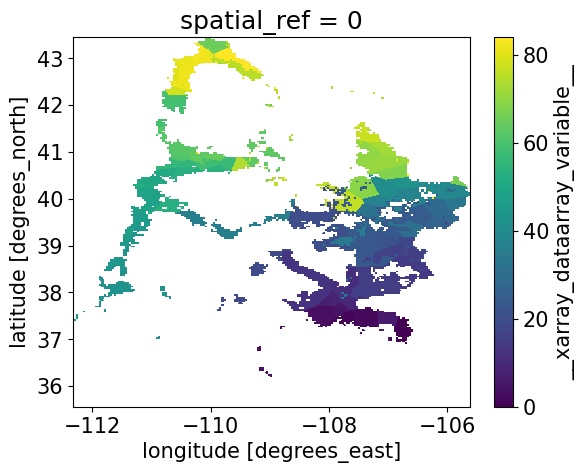

In [297]:
# Start by using the nearest within-cluster snotel id data array made in steps above:
nearest_station_sc_4326.plot()

In [299]:
# Make empty data array (with time dimension) to populate with nearest snotel's swe data:
nearest_station_swe_sc = xr.full_like(swe.SWE_Post, np.nan)

In [304]:
# populate this dataframe with that snotel's swe data:
site_ids = list(np.unique(nearest_station_sc_4326.data))
site_ids_nan = site_ids[0:-1]

for i in site_ids_nan:
    for year in range(0,32):
        nearest_station_swe_sc[year] = nearest_station_swe_sc[year].where((nearest_station_sc_4326 != i), stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['station_swe'].values[0])

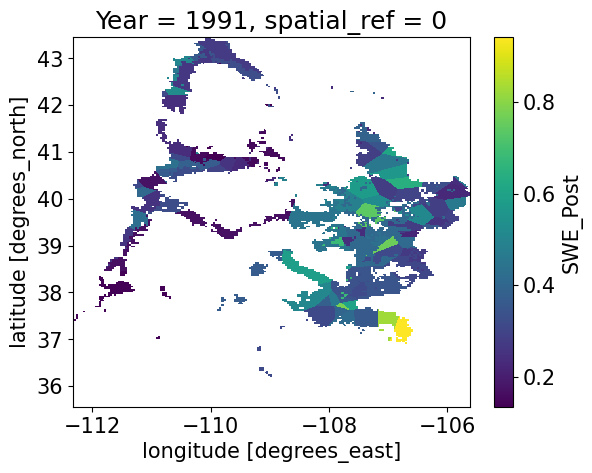

In [307]:
nearest_station_swe_sc[1].plot()

In [ ]:
# Test Chat GPT code for quantile mapping, based on Steven Pestana's code from DAWS:

In [308]:
from scipy.interpolate import interp1d

In [309]:
# Compute empirical CDFs
quantiles = np.linspace(0, 1, 100)

In [315]:
nearest_station_swe_sc.shape

(32, 1776, 1508)

In [328]:
# Empirical CDF for Slide Canyon (SLI_max)
station_ordered = np.apply_along_axis(np.sort, 0, nearest_station_swe_sc.values)  # Sorting along the time dimension

In [323]:
station_ordered.shape

(32, 1776, 1508)

In [337]:
# Empirical CDF for Slide Canyon (SLI_max)
station_sorted = np.sort(nearest_station_swe_sc.values, axis=0)  # Sorting along the time dimension
station_ordered = np.percentile(station_sorted, quantiles * 100, axis=0)

In [349]:
station_ordered[1,500,500]

nan

In [339]:
# Empirical CDF for Blue Canyon (BLC_max)
reanalysis_sorted = np.sort(swe.SWE_Post.values, axis=0)  # Sorting along the time dimension
reanalysis_ordered = np.percentile(reanalysis_sorted, quantiles * 100, axis=0)

In [351]:
reanalysis_ordered.quantile(station_ordered,dim='Year')

AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

In [340]:
# Interpolation functions
f_SLI = interp1d(quantiles, station_ordered, axis=0, fill_value='extrapolate')
g_BLC = interp1d(quantiles, reanalysis_ordered, axis=0, fill_value='extrapolate')

In [342]:
# Predict SWE in Blue Canyon using Slide Canyon data
BLC_predicted = g_BLC(f_SLI(nearest_station_swe_sc))

python(3116,0x10e348dc0) malloc: can't allocate region
:*** mach_vm_map(size=1836236311363584, flags: 100) failed (error code=3)
python(3116,0x10e348dc0) malloc: *** set a breakpoint in malloc_error_break to debug


MemoryError: Unable to allocate 1.63 PiB for an array with shape (85702656, 2678208) and data type float64

In [336]:
station_sorted.shape

(32, 1776, 1508)

In [333]:
station_ordered.shape

(100, 1776, 1508)

In [334]:
station_sorted.shape

(32, 1776, 1508)

In [331]:
np.nansum(station_sorted - station_ordered)

0.0

In [321]:
station_quantiles = np.linspace(0, 1, station_ordered.shape[0])

In [322]:
station_quantiles

array([0.        , 0.03225806, 0.06451613, 0.09677419, 0.12903226,
       0.16129032, 0.19354839, 0.22580645, 0.25806452, 0.29032258,
       0.32258065, 0.35483871, 0.38709677, 0.41935484, 0.4516129 ,
       0.48387097, 0.51612903, 0.5483871 , 0.58064516, 0.61290323,
       0.64516129, 0.67741935, 0.70967742, 0.74193548, 0.77419355,
       0.80645161, 0.83870968, 0.87096774, 0.90322581, 0.93548387,
       0.96774194, 1.        ])

In [310]:
# Empirical CDF for Slide Canyon (SLI_max)
station_ordered = np.apply_along_axis(np.sort, 0, nearest_station_swe_sc.values)  # Sorting along the time dimension
station_quantiles = np.linspace(0, 1, station_ordered.shape)

# Empirical CDF for Blue Canyon (BLC_max)
reanalysis_ordered = np.apply_along_axis(np.sort, 0, swe.SWE_Post.values)  # Sorting along the time dimension
reanalysis_quantiles = np.linspace(0, 1, reanalysis_ordered.shape[0])

In [316]:
station_ordered.shape

(32, 1776, 1508)

In [317]:
station_quantiles.shape

(32,)

In [ ]:

import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

# Assuming 'data' is an xarray Dataset containing variables 'SLI_max' and 'BLC_max'

# Create example data
x = np.linspace(0, 10, 20)
y = np.linspace(0, 5, 10)
time = np.arange(0, 100, 10)
SLI_data = np.random.randn(len(time), len(y), len(x))
BLC_data = np.random.randn(len(time), len(y), len(x))

# Create xarray DataArrays
SLI_da = xr.DataArray(SLI_data, dims=('time', 'y', 'x'), coords={'time': time, 'y': y, 'x': x})
BLC_da = xr.DataArray(BLC_data, dims=('time', 'y', 'x'), coords={'time': time, 'y': y, 'x': x})

# Compute empirical CDFs
quantiles = np.linspace(0, 1, 100)

# Empirical CDF for Slide Canyon (SLI_max)
SLI_ordered = np.apply_along_axis(np.sort, 0, SLI_da.values)  # Sorting along the time dimension
SLI_quantiles = np.linspace(0, 1, SLI_ordered.shape[0])

# Empirical CDF for Blue Canyon (BLC_max)
BLC_ordered = np.apply_along_axis(np.sort, 0, BLC_da.values)  # Sorting along the time dimension
BLC_quantiles = np.linspace(0, 1, BLC_ordered.shape[0])

# Interpolation functions
f_SLI = interp1d(SLI_quantiles, SLI_ordered, axis=0, fill_value='extrapolate')
g_BLC = interp1d(BLC_quantiles, BLC_ordered, axis=0, fill_value='extrapolate')

# Predict SWE in Blue Canyon using Slide Canyon data
BLC_predicted = g_BLC(f_SLI(SLI_da))

# BLC_predicted now contains the predicted SWE values for Blue Canyon based on Slide Canyon data

# Optionally, convert back to xarray DataArray if needed
BLC_predicted_da = xr.DataArray(BLC_predicted, dims=('time', 'y', 'x'), coords={'time': time, 'y': y, 'x': x})


In [ ]:
# Compute empirical CDFs
quantiles = np.linspace(0, 1, 100)

# Empirical CDF for Slide Canyon (SLI_max)
SLI_sorted = np.sort(SLI_da.values, axis=0)  # Sorting along the time dimension
SLI_ordered = np.percentile(SLI_sorted, quantiles * 100, axis=0)

# Empirical CDF for Blue Canyon (BLC_max)
BLC_sorted = np.sort(BLC_da.values, axis=0)  # Sorting along the time dimension
BLC_ordered = np.percentile(BLC_sorted, quantiles * 100, axis=0)

# Interpolation functions
f_SLI = interp1d(quantiles, SLI_ordered, axis=0, fill_value='extrapolate')
g_BLC = interp1d(quantiles, BLC_ordered, axis=0, fill_value='extrapolate')

# Predict SWE in Blue Canyon using Slide Canyon data
BLC_predicted = g_BLC(f_SLI(SLI_da))

# Converting predicted values back to xarray DataArray for consistency
BLC_predicted_da = xr.DataArray(BLC_predicted, dims=('time', 'y', 'x'), coords={'time': time, 'y': y, 'x': x})


### Plot PRISM Cumulative Cold Season Precip:

In [191]:
cs_precip = xr.open_dataarray('../data/calculated_swe/calculated_swe_prism_cumulative_coldseason_precip.nc')

In [195]:
swe2 = swe.rename(Year="time")
swe2['time'] = xr.cftime_range(start="1990", periods=32, freq="YS-APR", calendar="noleap")

In [196]:
prism_dif = cs_precip.where(swe2.SWE_Post.mean(dim='time')>0.1) - swe2.SWE_Post.where(swe2.SWE_Post.mean(dim='time')>0.1)

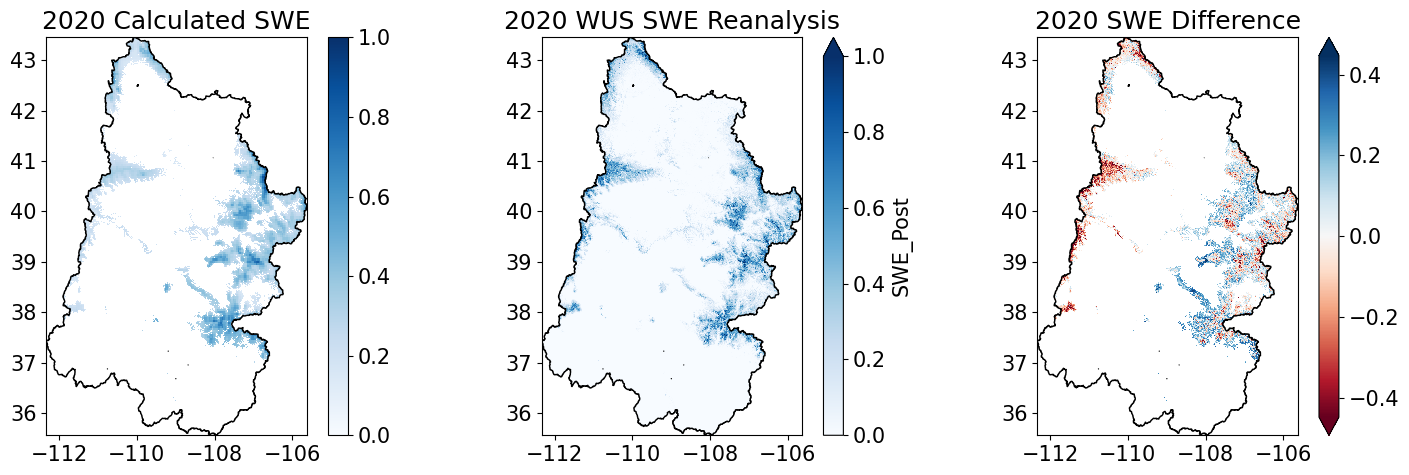

In [198]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,3, figsize=(15,5))

cs_precip.sel(time='2020').plot(cmap='Blues', ax=ax[0], vmin=0,vmax=1)
ucrb.plot(ax=ax[0], facecolor='none', edgecolor='k')
swe2.SWE_Post.sel(time='2020').plot(cmap='Blues', ax=ax[1], vmin=0,vmax=1)
ucrb.plot(ax=ax[1], facecolor='none', edgecolor='k')
prism_dif.sel(time='2020').plot(cmap='RdBu', ax=ax[2], robust=True)
ucrb.plot(ax=ax[2], facecolor='none', edgecolor='k')

ax[0].set_title('2020 Calculated SWE')
ax[1].set_title('2020 WUS SWE Reanalysis')
ax[2].set_title('2020 SWE Difference')

ax[0].set_xlabel('')
ax[0].set_ylabel('')

ax[1].set_xlabel('')
ax[1].set_ylabel('')

ax[2].set_xlabel('')
ax[2].set_ylabel('')

plt.tight_layout()
#plt.savefig('../figures/calculated_swe_mean_snv_2020.jpeg',dpi=300)

## Plot all metrics:

In [147]:
sca = []

for year in np.arange(0,32):
    sca.append(np.sum(swe.SWE_Post[year] == 0).values)

sca_perc = ((swe.SWE_Post[0].count().values - sca) / swe.SWE_Post[0].count().values) *100

In [179]:
data = {
  "Rs": Rs,
    "MDs": MDs,
    "RMSEs": RMSEs,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"mean_wic",
    "method": "SNV"
}

#load data into a DataFrame object:
mean_df = pd.DataFrame(data)

In [180]:
data = {
  "Rs": R_scs,
    "MDs": MD_scs,
    "RMSEs": RMSE_scs,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"Mean SNV of within-cluster stations",
    "method": "SNV"
}

#load data into a DataFrame object:
mean_sc_df = pd.DataFrame(data)

In [181]:
data = {
  "Rs": R_scs2,
    "MDs": MD_scs2,
    "RMSEs": RMSE_scs2,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"mean_wic_sc2",
    "method": "SNV"
}

#load data into a DataFrame object:
mean_sc_df2 = pd.DataFrame(data)

In [183]:
data = {
    "Rs": R2s,
    "MDs": MD2s,
    "RMSEs":RMSE2s,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"nearest_wic",
    "method": "SNV"
}

#load data into a DataFrame object:
nearest_wic_df = pd.DataFrame(data)

In [182]:
data = {
    "Rs": R2s_sc,
    "MDs": MD2s_sc,
    "RMSEs":RMSE2s_sc,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"SNV of nearest within-cluster station",
    "method": "SNV"
}

#load data into a DataFrame object:
nearest_wic_sc_df = pd.DataFrame(data)

In [184]:
data = {
    "Rs" : R3s, 
    "MDs": MD3s,
    "RMSEs":RMSE3s,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"SNV of nearest station",
    "method": "SNV"
}

#load data into a DataFrame object:
nearest_df = pd.DataFrame(data)

In [186]:
data = {
    "Rs" : R4s, 
    "MDs": MD4s,
    "RMSEs":RMSE4s,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"Mean SNV of all stations",
    "method": "SNV"
}

#load data into a DataFrame object:
all_mean_df = pd.DataFrame(data)

In [188]:
data = {
    "Rs" : R_scqs, 
    "MDs": MD_scqs,
    "RMSEs":RMSE_scqs,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"Quantile of nearest within-cluster station",
    "method": "Quantile"
}

#load data into a DataFrame object:
nearest_wic_quantile = pd.DataFrame(data)

In [255]:
data = {
    "Rs" : R_scq2s, 
    "MDs": MD_scq2s,
    "RMSEs":RMSE_scq2s,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"Mean Quantile of within-cluster stations",
    "method": "Quantile"
}

#load data into a DataFrame object:
wic_mean_quantile = pd.DataFrame(data)


In [264]:
data = {
    "Rs" : R_scq2ys, 
    "MDs": MD_scq2ys,
    "RMSEs":RMSE_scq2ys,
    'year': np.arange(1990,2022),
    'sca_percent': sca_perc,
    "version":"Mean Quantile of w/in-cluster stations Yr",
    "method": "Quantile"
}

#load data into a DataFrame object:
wic_mean_quantile_yr = pd.DataFrame(data)

In [187]:
data = {
    "Rs" : Rs_precip, 
    "MDs": MDs_precip,
    "RMSEs":RMSEs_precip,
    "version":"cumulative cold-season precipitation",
    "method": "Precipitation"
}

#load data into a DataFrame object:
prism_precip = pd.DataFrame(data)

In [265]:
metrics = pd.concat([all_mean_df, nearest_df, nearest_wic_sc_df, mean_sc_df, nearest_wic_quantile, prism_precip, wic_mean_quantile,wic_mean_quantile_yr], ignore_index=True)

In [161]:
import altair as alt

In [266]:
r_chart = alt.Chart(metrics).mark_boxplot(extent=1).encode(
    alt.X("Rs:Q").scale(zero=False),
    alt.Y("version:N"),
    alt.Color("method")
)

md_chart = alt.Chart(metrics).mark_boxplot(extent=1).encode(
    alt.X("MDs:Q").scale(zero=False),
    alt.Y("version:N"),
    alt.Color("method")
)

rmse_chart = alt.Chart(metrics).mark_boxplot(extent=1).encode(
    alt.X("RMSEs:Q").scale(zero=False),
    alt.Y("version:N"),
    alt.Color("method")
)

concat = alt.vconcat(r_chart, md_chart, rmse_chart)
concat

alt.VConcatChart(...)

In [295]:
r_chart = alt.Chart(metrics).mark_boxplot().encode(
    alt.X("Rs:Q").scale(zero=False),
    alt.Y("version:N")
)

md_chart = alt.Chart(metrics).mark_boxplot().encode(
    alt.X("MDs:Q").scale(zero=False),
    alt.Y("version:N")
)

rmse_chart = alt.Chart(metrics).mark_boxplot().encode(
    alt.X("RMSEs:Q").scale(zero=False),
    alt.Y("version:N")
)

concat = alt.vconcat(r_chart, md_chart, rmse_chart)
concat

alt.VConcatChart(...)

* Next I will plot these metrics against each other for each year. Then, I will find which years have outlier snow cover area, and see if those years show weird metrics for any of these version, or whether some of these versions can mitigate the issues with weird years.  
* I will test the distributions using the test Danny sent me - test normal, lognormal, and gamma.  
* If I have time, I will test the quantile mapping again?

Text(0, 0.5, 'Nearest within-cluster SNV')

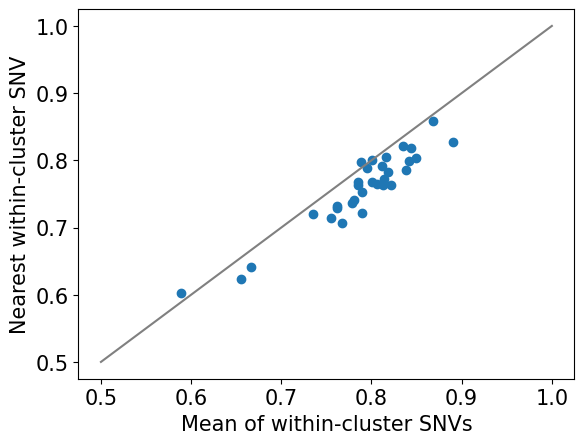

In [167]:
data = {'x': np.linspace(0.5,1,100),
        'y': np.linspace(0.5,1,100)}
df_lin = pd.DataFrame(data)

fig, ax = plt.subplots()

ax.scatter(R_scs, R2s_sc)
ax.plot(df_lin['x'], df_lin['y'], color='grey')

ax.set_xlabel('Mean of within-cluster SNVs')
ax.set_ylabel('Nearest within-cluster SNV')

Text(0, 0.5, 'Nearest within-cluster SNV')

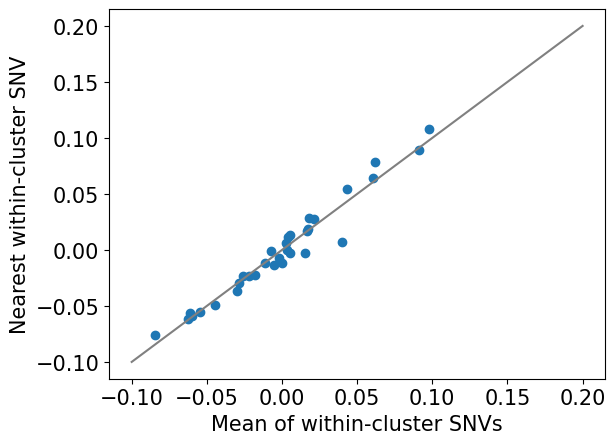

In [169]:
data = {'x': np.linspace(-0.1,0.2,100),
        'y': np.linspace(-0.1,0.2,100)}
df_lin = pd.DataFrame(data)

fig, ax = plt.subplots()

ax.scatter(MD_scs, MD2s_sc)
ax.plot(df_lin['x'], df_lin['y'], color='grey')

ax.set_xlabel('Mean of within-cluster SNVs')
ax.set_ylabel('Nearest within-cluster SNV')

Text(0, 0.5, 'Nearest within-cluster SNV')

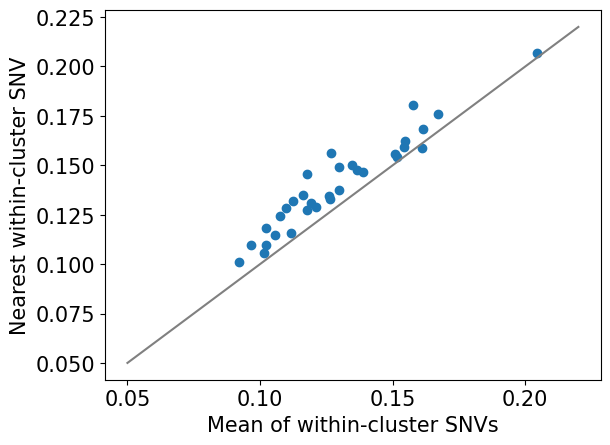

In [172]:
data = {'x': np.linspace(0.05,0.22,100),
        'y': np.linspace(0.05,0.22,100)}
df_lin = pd.DataFrame(data)

fig, ax = plt.subplots()

ax.scatter(RMSE_scs, RMSE2s_sc)
ax.plot(df_lin['x'], df_lin['y'], color='grey')

ax.set_xlabel('Mean of within-cluster SNVs')
ax.set_ylabel('Nearest within-cluster SNV')

In [174]:
metrics

Rs       MDs     RMSEs      version
0    0.786715 -0.025591  0.112247     mean_wic
1    0.754984  0.017818  0.116195     mean_wic
2    0.651154 -0.069391  0.198955     mean_wic
3    0.796870 -0.005370  0.129071     mean_wic
4    0.780305  0.028588  0.106673     mean_wic
..        ...       ...       ...          ...
187  0.835034  0.039804  0.160989  mean_wic_sc
188  0.815823  0.000305  0.101343  mean_wic_sc
189  0.784523 -0.002126  0.136402  mean_wic_sc
190  0.800911  0.015196  0.120906  mean_wic_sc
191  0.666469 -0.005117  0.126415  mean_wic_sc

[192 rows x 4 columns]

In [230]:
sca_chart = alt.Chart(metrics).mark_circle().encode(
    alt.Y("sca_percent:Q").scale(zero=False),
    alt.X('year:O'),
    alt.Color('version:N'),
    tooltip=['Rs', 'MDs', 'RMSEs', 'version', 'sca_percent','year']
)

r_chart = alt.Chart(metrics).mark_circle().encode(
    alt.Y("Rs:Q").scale(zero=False),
    alt.X('year:O'),
    alt.Color('version:N'),
    tooltip=['Rs', 'MDs', 'RMSEs', 'version', 'sca_percent', 'year']
)

md_chart = alt.Chart(metrics).mark_circle().encode(
    alt.Y("MDs:Q").scale(zero=False),
    alt.X('year:O'),
    alt.Color('version:N'),
    tooltip=['Rs', 'MDs', 'RMSEs', 'version', 'sca_percent', 'year']
)

rmse_chart = alt.Chart(metrics).mark_circle().encode(
    alt.Y("RMSEs:Q").scale(zero=False),
    alt.X('year:O'),
    alt.Color('version:N'),
    tooltip=['Rs', 'MDs', 'RMSEs', 'version', 'sca_percent', 'year']
)

concat = alt.vconcat(sca_chart, r_chart, md_chart, rmse_chart)
concat

alt.VConcatChart(...)

In [284]:
sca_chart = alt.Chart(metrics).mark_circle().encode(
    alt.Y("sca_percent:Q").scale(zero=False),
    alt.X('year:O'),
    alt.Color('version:N'),
    tooltip=['Rs', 'MDs', 'RMSEs', 'version', 'sca_percent','year']
)

r_chart = alt.Chart(metrics).mark_circle().encode(
    alt.Y("Rs:Q").scale(zero=False),
    alt.X('sca_percent:Q'),
    alt.Color('version:N'),
    tooltip=['Rs', 'MDs', 'RMSEs', 'version', 'sca_percent', 'year']
)

md_chart = alt.Chart(metrics).mark_circle().encode(
    alt.Y("MDs:Q").scale(zero=False),
    alt.X('sca_percent:Q'),
    alt.Color('version:N'),
    tooltip=['Rs', 'MDs', 'RMSEs', 'version', 'sca_percent', 'year']
)

rmse_chart = alt.Chart(metrics).mark_circle().encode(
    alt.Y("RMSEs:Q").scale(zero=False),
    alt.X('sca_percent:Q'),
    alt.Color('version:N'),
    tooltip=['Rs', 'MDs', 'RMSEs', 'version', 'sca_percent', 'year']
)

concat = alt.vconcat(r_chart, md_chart, rmse_chart) #sca_chart, 
concat

alt.VConcatChart(...)

In [285]:
np.corrcoef(metrics['MDs'],metrics['sca_percent'])[0,1]

0.2574043769140145

In [286]:
np.corrcoef(metrics['RMSEs'],metrics['sca_percent'])[0,1]

0.2966176767262307

In [287]:
np.corrcoef(metrics['Rs'],metrics['sca_percent'])[0,1]

-0.05450955000443693

In [288]:
np.corrcoef(metrics[metrics['version']=='mean_wic_sc']['MDs'],metrics[metrics['version']=='mean_wic_sc']['sca_percent'])[0,1]

0.2839301963484759

In [289]:
np.corrcoef(metrics[metrics['version']=='mean_wic_sc']['RMSEs'],metrics[metrics['version']=='mean_wic_sc']['sca_percent'])[0,1]

0.27631242365191216

In [290]:
np.corrcoef(metrics[metrics['version']=='mean_wic_sc']['Rs'],metrics[metrics['version']=='mean_wic_sc']['sca_percent'])[0,1]

-0.07707610021954385

Justin found the biggest changes in the relationship between the standard deviation and the mean at SCAs between 0.7 and 1. We don't have values in this range, because I"m using the whole UCRB instead of a small alpine basin. I do see a potential increase in MD and RMSE with SCA, but it's pretty weak (haven't run any regression on this relationship though). 

### Try to recreate Justin's SCA plot?

In [ ]:
.where(swe.SWE_Post.mean(dim='Year')>0.1)

In [ ]:
swe_calc_nearest_sc[year] = nearest_snv_sc[year] * swe.SWE_Post.sel(Year=years).std(dim='Year', skipna=True, ddof=1).where(swe.SWE_Post.mean(dim='Year')>0.1) + swe.SWE_Post.sel(Year=years).mean(dim='Year').where(swe.SWE_Post.mean(dim='Year')>0.1)

In [238]:
cv = []

for year in np.arange(1990,2022):
    cv.append(swe.SWE_Post.sel(Year=year).std(dim=['x','y'], skipna=True, ddof=1).values / swe.SWE_Post.sel(Year=year).mean(dim=['x','y'], skipna=True).values)

Text(0, 0.5, 'CV')

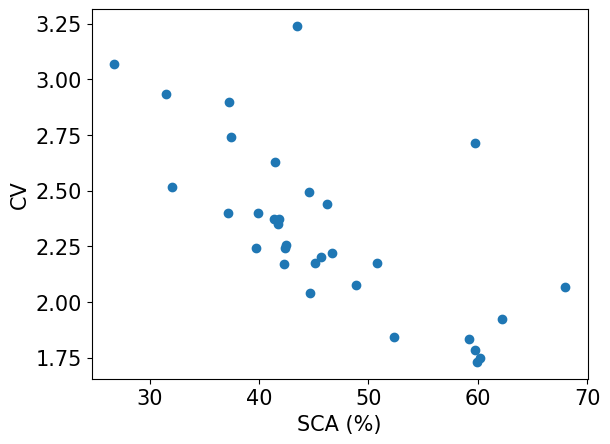

In [243]:
fig, ax = plt.subplots()
plt.scatter(sca_perc,cv)
plt.xlabel('SCA (%)')
plt.ylabel('CV')

In [245]:
np.corrcoef(sca,cv)[0,1]

0.6842177464006425

But this is the standard deviation and mean through space, not time...

In [220]:
sca_perc

array([32.07400099, 39.68516476, 37.12316012, 59.95890985, 44.53610004,
       42.44223149, 39.85570697, 67.98794396, 62.17370011, 59.76804195,
       42.27265717, 45.66911199, 41.45130578, 41.33283605, 37.26324606,
       44.61288597, 45.08540983, 37.40320294, 59.21847405, 41.74096297,
       59.75836305, 52.31038552, 43.48445537, 41.798133  , 42.41377553,
       26.74718651, 48.82475579, 46.25003952, 31.49597713, 60.24011413,
       50.75763197, 46.63016216])

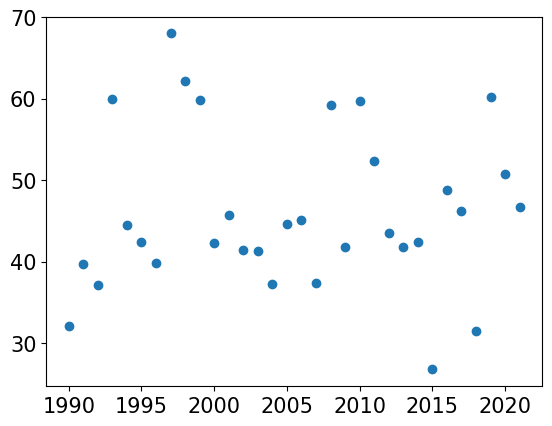

In [221]:
plt.scatter(np.arange(1990,2022),sca_perc)

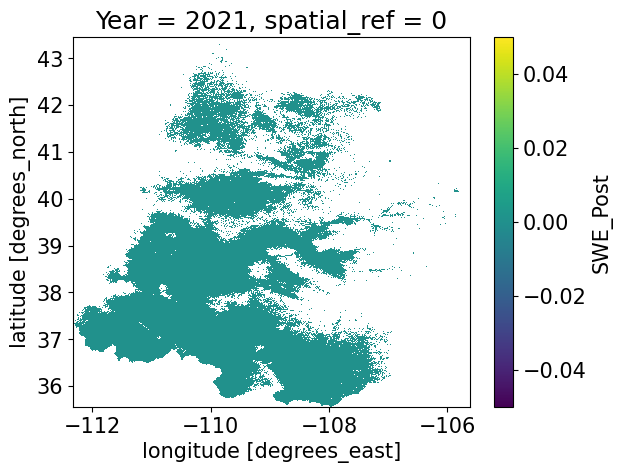

In [207]:
swe.SWE_Post[year].where(swe.SWE_Post[year]==0).plot()

In [199]:
swe.SWE_Post[year].count(dim=["x", "y"])

<xarray.DataArray 'SWE_Post' ()> Size: 8B
array(1549763)
Coordinates:
    Year         int64 8B 2021
    spatial_ref  int64 8B ...

In [191]:
(1776 * 1508)

2678208

In [70]:
wstates = gpd.read_file('../data/misc/western_states.shp')
wstates_4326=wstates.to_crs('epsg:4326')

<Axes: >

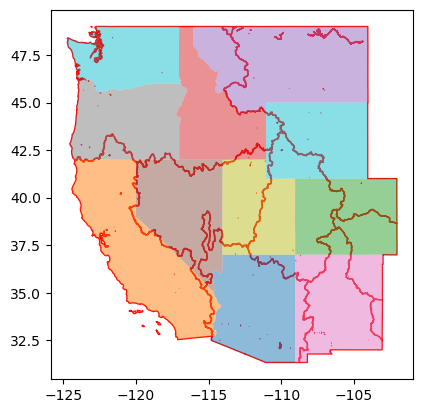

In [76]:
fig, ax = plt.subplots()
huc2.plot(ax=ax, facecolor='none', edgecolor='red')
wstates_4326.plot(ax=ax, column='NAME',edgecolor='none', alpha=0.5)

In [78]:
stations_ucrb.columns

Index(['station_n', 'reanalysis_n', 'elevation_m', 'station_swe',
       'station_swe_mean', 'reanalysis_swe', 'deg_days_0C', 'cold_deg_days',
       'cumulative_precip_m', 'precip_mean', 'precip_std', 'precip_n',
       'log_cumulative_precip_m', 'log_reanalysis_swe', 'log_station_swe',
       'log_precip_mean', 'log_station_swe_mean', 'log_reanalysis_swe_mean',
       'log_precip_std', 'log_station_swe_std', 'log_reanalysis_swe_std',
       'log_precip_n', 'log_station_n', 'log_reanalysis_n', 'latitude',
       'longitude', 'geometry', 'cluster'],
      dtype='object')